# Google Colab Ayarları

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Kodlayan ve Kodlanan hakkında bilgiler :)
#### Ad , Soyad , Numara , Şube : EREN KARA B211210031  1/B
#### Algoritma : Pix2PixGAN https://github.com/bnsreenu/python_for_microscopists/tree/master/251_satellite_image_to_maps_translation
#### DatasetOrnek : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
#### DatasetBen : https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic

# 1. Pix2Pix Nedir

Based on the code by Jason Brownlee from his blogs on https://machinelearningmastery.com/  
I seriously urge everyone to foloow his blogs and get enlightened.  
I am adapting his code to various applications but original credit goes to Jason.  

    Original paper: https://arxiv.org/pdf/1611.07004.pdf
    Github for original paper: https://phillipi.github.io/pix2pix/
    
    
### Generator'ı ve Discriminator'ı paper'da bizlere yapmamız gerektiği söylenen şekilde yapacağız.

Aşağıdaki Görünen C..'ler bizlerin layer olarak kullandığı convolutional layerlardaki filtreleri temsil ediyor.  
Makalede Generator bir U-Net'miş Discriminator ise PatchGAN.  
Peki PatchGAN ve U-NET nedir:
##### U-Net: Segmentasyon yapmaya yarayan bir yapı olarak düşünebiliriz.  Dahasına odevden sonra zaman bulduğumda bakacağım çok kapsamlı bir konu gibi duruyordu.
##### PatchGAN: Discriminator'da, normalde bizler 1 tane real or fake diye sınıflandırma yapıyoruz ve ona göre işlemlerimize devam ediyoruz. Ancak PatchGan kendisine verilen bir Patch boyutu kadar bir bölgeyi real or fake diye sınıflandırıyor. Bütün resmi convolutional şekilde bu patch'den geçirdikten sonra ortaya daha düşük boyutlarda bir matris çıkıyor. Bu matris her bir patch'in real mi fake mi oldugunu içeren bir matris. En son ise bu matrisin ortalaması mı alınıyor ya da soft pooling mi yapılıyor her neyse sonuç olarak 1 tane real or fake uretiliyor.


Generator:    
The encoder-decoder architecture consists of:  
encoder:  
C64-C128-C256-C512-C512-C512-C512-C512  
decoder:   
CD512-CD512-CD512-C512-C256-C128-C64   


Discriminator  
C64-C128-C256-C512  
After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function.
  
##### Makalede bir çok metric üzerinde durulmuş alpha rate'inden LeakyRelu'nun kullanılması ve hatta hangi derecede kullanılmasına kadar.
##### Ben de makaleye biraz baktım. Makalenin özetini yapan bir tane kanal buldum ve anladığım kadarıyla notlar üzerinde açıklayarak ilerleyeceğim

### Benim izleyerek ogrendiğim youtube kanalı
https://github.com/bnsreenu/python_for_microscopists/tree/master/251_satellite_image_to_maps_translation  
https://www.youtube.com/watch?v=UcHe0xiuvpg&list=PLZsOBAyNTZwboR4_xj-n3K6XBTweC4YVD&index=7  
https://youtu.be/UcHe0xiuvpg  
https://youtu.be/6pUSZgPJ3Yg  
https://youtu.be/my7LEgYTJto  

# ÖRNEK
Uydu görüntüsündenn map görüntüsüne image translation işlemi.  ​Pix2Pix GAN kullanılarak  
Data : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz  
Başka dataset'ler için : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/  

Kayknak kod, kuş bakışı street view ile eşleşmiş olduğu map görüntüleri için hazırlanmıştı. Ben de kendime uyarladım.    

# Benim kullandığım örnek

### https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic  

Gerçek yüzlere ve eşlenmiş oldukları çizgi roman yüzlerine bakarak oluşturulmuş datasetini kullanarak model eğittim.  
Model eğittikten sonra herhangi bir yüzü çizgi roman stiline çeviriyorum.  
COLAB sürekli hata verdiği için ve benim GPU kullanmama izin vermediği için modeli yalnızca kendi bilgisayarımda 2 epoch olacak kadar eğitebildim.

# 2. Dependencies

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import os

# 3. Discriminator'un Tanımlanması

In [2]:
#Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label
#For pix2pix the label will be another image.

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
#Think of discriminator as a binary classifier that is classifying images as real/fake.

# From the paper C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.

# Discriminator'ımız binary classification yapıyor yapmasına ancak bunu her bir patch için yapyıor.
# En son ortaya koyduğu matrisin bir daha ortalaması alınarak sigmoid fonksiyonundan geçirilebilir.

def define_discriminator(image_shape):

	# weight initialization
    # Burada RandomNormal makale'de kullanılması istenilen kernel initilaizer'mış. Tam olarak ne işe yaradığını anlamadım.
    # Okuma yaparsam güncellerim burayı
	init = RandomNormal(stddev=0.02) #As described in the original paper

	# source image input
    # Ornegin sokak fotoğraflarına (uydu görüntüsü) bakarak
    # Map'lenmiş haritası çıkarılmış bir görüntü istiyoruz işte uydu görntüsü source image oluyor
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
    # Target image ise uydu görüntüsünün map'lenmiş hali oluyor.
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

	# concatenate images, channel-wise
    # ikisini channel olarak birbirine ekledik ornegin 32x32'lik bir elimizde image varsa bu image'in
    # 3 tane channel'dan (RGB) olustugunu dusunursek ekstra olarak diger image'ide concatenate ettigmizden toplamda
    # 6 tane channel'dan olusan 32x32'lik bir image elde ediyoruz gibi oluyor. Tek bir image gibi degil'de katman katman
    # arka arkaya dizilmiş matrisler gibi düşünebilirsin.
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
    # Yine burada 1 tane layer kullanmamız gerektiğini makalede bizlere söylemiş.
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
    # Modele iki tane input vereceğiz ve 1 tane output alcağız diyoruz.
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.

    # learning rate'i makale'de böyle belirlemiş.
    # Sanırım beta_1'i 0.999'da verebiliyoruz.
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# 4. Encoder Blokları Tanımlamak

In [3]:
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# 5. Decoder Blokları Tanımlamak

In [4]:
# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# 6. Generator'ı Tanımlama

In [5]:
# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	# weight initialization
    # Burada RandomNormal makale'de kullanılması istenilen kernel initilaizer'mış. Tam olarak ne işe yaradığını anlamadım.
    # Okuma yaparsam güncellerim burayı.
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
    # U-NET'in mantığı ilk önce boyut küçültmek onda sonra'da boyut büyültmek. Aşağıdaki encoder ve decoderlar onu yapıyorlar.
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
    # 512 tane 4x4'lük filtereye sahip convolutional layer 2'şer 2'şer horizantal ve vertical hareket edecekler.
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
    # Aşağıda son bir boyut arttıma yapılmış aşağıdaki ifade orjinal image'i iki katı boyutuna çıkarmaya yarıyor
    # Upsampling'den farklı bunu convolutional yol ile yapıyor olması.
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
    # Inputlar'ımızı scale etmeliyiz cunku output olarak tanh fonksiyonu kullandık.
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

# 7. Generator ve Discriminator'ı ortak bir neural networkde birbirinin ucuna eklemek

In [6]:
# BURADA YAPTIGIMIZ ŞEY:
# Normalde Generator'ın çıktısını discrimiator'a vererek eğitme işlemini gerçekleştiriyoruz.
# Bunu direkt olarak generator'ın network'ünü discriminator network'üne bağlayarak gerçekleştirebiliriz.
# Ancak burdaki dikkat edilmesi gereken husus generator'ı egitirken discriminator'ı eğitmemek.
# Bu yüzden trainable kısmını false yapıyoruz.
# Discriminator ve Generator birbirlerinden ayrı olarak eğitilecekler.
# KISACA : Asagida kurdumuz GAN yapısı bizlere Generator'ın ve Discriminator'ın birleşmiş bir halini veriyor.

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator

    # discriminator input olarak iki şey bekliyor. Bir gerçek soruce image bir generator tarafından olusturulmus
    # pair edilmiş Map image.
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
    # input olarak generator oldugundan source image'i vereceğiz ve sonucunda
    # Burada output olarak generator'un olusturmus oldugu image'i de istiyoruz cunku MeanAverageError(MAE) Loss hesabı yapacağız.
    # Train ederken 1 tane sınıflandırması için real or fake label'i vereceğiz
    # Diğeri ise gerçek Map Görüntüsü olacak. Bu outputlardan birin real or fake ile loss'u alınacak diğerinin Map image ile.
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.

    # Burada MeanError'un rate'i 100 iken, binary crossentropy'nin 1
    # Binary crossentropy dicsriminator'ın tahmin ettiği değerden elde edilen loss. Yani eğerki discriminator fake derse
    # kendisini düzeltmesi için generato'ı optimize edicez.
    # MAE ise elimizdeki paired olan image'e (Harita Goruntusu) bakarak olusturduğumuz bir loss function oluyor.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

# 8. Veri Kümesinden Veri Çekmek

In [7]:
# select a batch of random samples, returns images and target
# Karma olayı yapmadan veri seti ile besliyorum
# ileride karma yaparak veriler seçilebilir
# Ancak suanki ornegimde paired yaparak nasıl shuffle edicem ugrasmadım. Denenebilir.
def generate_real_samples(pipelineSource_iterator,pipelineTarget_iterator, n_samples, patch_shape):
    # iterator'lerden batch kadar yeni fotograf cektim.
    # [0] yapmamızın sebebi pipeline olsuturdgumuz sııf bunları kalsorlere göre etiketleme ypaıyor
    # onda dolayı klasor lablelarından kurtulmak için [0] yaptık.
    X1 = pipelineSource_iterator.next()[0]
    X2 = pipelineTarget_iterator.next()[0]
    # burada ones içerisine shape'ini veriyoruz. 4 boyut var.
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# 9. Generator'a Fake Image'ler Yaptırmak

In [8]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# 10. Training Fonksiyonu'nun Tanımlanması

In [9]:
# train pix2pix models
def train(d_model, g_model, gan_model, pipelineSource , pipelineTarget, n_epochs=100, n_batch=1):

    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(pipelineSource) / n_batch)
    # calculate the number of training iterations
    # manually enumerate epochs
    bat_per_epo= bat_per_epo-20
    for i in range(n_epochs):
        # iterator olusturdum train basladıgında her bir epoch'ta sonucta sıfırlamamız gerekecek iterator'leri
        pipelineSource_iterator = pipelineSource.as_numpy_iterator()
        pipelineTarget_iterator = pipelineTarget.as_numpy_iterator()

        for j in range(bat_per_epo):
            # select a batch of real samples
            [X_real_source, X_real_target], y_real = generate_real_samples(pipelineSource_iterator,pipelineTarget_iterator, n_batch, n_patch)
            # generate a batch of fake samples
            #print("X_real_source: ",X_real_source.shape)
            #print("X_real_target: ",X_real_target.shape)
            #print("y_real: ",y_real.shape)
            X_fake_target, y_fake = generate_fake_samples(g_model, X_real_source, n_patch)
            #print("X_fake_target: ",X_fake_target.shape)
            #print("y_fake: ",y_fake.shape)

            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_real_source, X_real_target], y_real)
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_real_source, X_fake_target], y_fake)
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_real_source, [y_real, X_real_target])
            print('epoch:%d, batch %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1,j+1, d_loss1, d_loss2, g_loss))

# 11. GAN EGİTİMİ UZUN SURDUGUNDEN KAYDEDİP KONTROL ETME

In [10]:
# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks.
def summarize_performance(step, g_model, pipelineSource_iterator , pipelineTarget_iterator, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(pipelineSource_iterator , pipelineTarget_iterator, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# 12. VERİ KUMESİ İLE UGRASMA

In [11]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

# 13. Image'leri Yukleme

In [12]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
        # pixels = load_img(os.path.join(path,filename),target_size=size)
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		src_list.append(pixels)
	return asarray(src_list)


# dataset path
path = 'ComicFaces/BenimResimlerim/'
# load dataset
src_list = load_images(path)
print('Loaded: ', src_list.shape)

Loaded:  (3, 256, 256, 3)


### Usttekini yapmak yerine -> DATA PIPELINE'I OLUSTURMAK

In [13]:
# TensorFlow bizlere data pipeline'ı oluşturmamıza izin veren Dataset API'ı sunuyor
# bu sayade bütün datasetini memory'ye yukelemeden istedigimiz işlemleri gerceklestirebiliyoruz.
# tf.data.Dataset??

In [ ]:
# tf.keras.utils.image_dataset_from_directory??

In [41]:
# Bu fonksyion bizi için resimleri scale etmek dahil bir çok preprocess işlemini gerçekleştiriyor.
# Eğerki fonksiyonun paramerelerine bakmak istersen ki yukarı ?? fonksiyonun sonuna 2 tane soru isareti koyarak bunu yapabilyiorsun
# fonksiyonun parametrelerine bak ve istedigin gibi kullan.
facePipeline= tf.keras.utils.image_dataset_from_directory(os.path.join("ComicFaces","faces"), batch_size=1,image_size=(256,256),shuffle=False)
comicPipeline = tf.keras.utils.image_dataset_from_directory(os.path.join("ComicFaces","comics"), batch_size=1,image_size=(256,256),shuffle=False)
# Bu data memory'ye yuklenmis bir array veya herhangi bir dataset'i degil
# Ondan tek tek veya istenilen miktarda veri cekmeni bekleyen bir pipeline. Bir iterator gibi

Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.


In [14]:
comicPipeline_iterator = comicPipeline.as_numpy_iterator()
facePipeline_iterator = facePipeline.as_numpy_iterator()
# batch = data_iterator.next()

# Burada batch 2 tane şeyden oluşmakta birincisi numpy array olarak resimelrden ikincisi ise bu resimlerin labellarından
# batch[0].shape

# Batch'in bu ikinci parametresi label ancak bu label islemini nasıl yapıyor:
# ust klasor olan data klasorunun altında olan diger 2 sınıf ki bunlar happy ve sad. Bunları label 0 ve label 1 olarak isaretliyor
# fotografi hangi klasorden cektiyse label'ıda ona göre veriyor.

# Class-0 = Happy PEOPLE
# Class-1 = Sad PEOPLE
# batch[1]

# 14. Yuklenen DataSetini Kontrol Etme

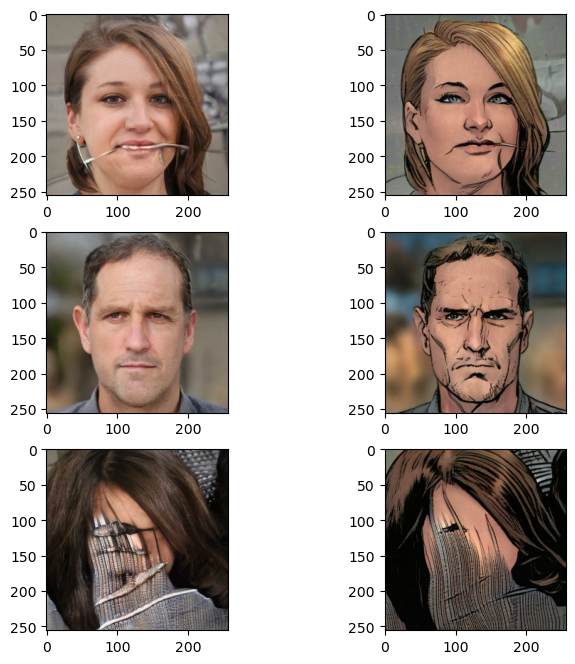

In [24]:
n_samples = 3

# plt.imshow(np.squeeze(comicPipeline_iterator.next()[0]).astype(int))
# plt.imshow(np.squeeze(facePipeline_iterator.next()[0]).astype(int))

fig, ax = plt.subplots(ncols=2,nrows=n_samples, figsize=(8,8))
for i in range(n_samples):
    ax[i][1].imshow(np.squeeze(comicPipeline_iterator.next()[0]).astype(int))
    ax[i][0].imshow(np.squeeze(facePipeline_iterator.next()[0]).astype(int))

# 15. Instance Olusturma

In [15]:
# define input shape based on the loaded dataset
from keras.models import load_model
image_shape = np.squeeze(comicPipeline.as_numpy_iterator().next()[0]).shape # 256x256x3
# define the models
d_model = define_discriminator(image_shape)
# g_model = define_generator(image_shape)
g_model = load_model('comicGAN1epoch.h5')
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

C:\Users\Eren\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


# 16. Preprocess Data

In [16]:
# Burada 255'e bolecek slace islemini gerceklstirdik
# renk kanalı 3 olan (RGB) bu resimlerin renk kanallarındaki sayı aralıkları 0-255 oldugundan ve bizim onalrı 0-1 arasına
# indirgersek daha hızlı calisacagimizdan doalyı bu resimelri scale ettik.
# Burada her bir datapipeline'ından çektiktens orna bu silemi uygulamamak icin pipeline'ın hepsine uygulanması icin
# map fonksiyonu aracılı ile lambda expresison oalrakv eridigimiz bu fonksiyonu data seti icerisindeki butun fonksiyonalra uygulattırdık.

# Bu islem pipeline'dan resimler cekilirken uygulanıyor o yüzden isimiz cok daha kolaylasıyor.

# Buradaki x verilerimiz yani array'imiz olacak iken y ise bu resimlerin labelları olacak.
comicPipeline = comicPipeline.map(lambda x,y: ((x - 127.5)/127.5, y))
facePipeline = facePipeline.map(lambda x,y: ((x - 127.5)/127.5, y))

# 17. TRAINING

In [25]:
from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, facePipeline,comicPipeline, n_epochs=1, n_batch=1)


stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)


1/1 [==============================] - 0s 150ms/step
epoch:1, batch 1, d1[0.293] d2[1.122] g[14.894]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 2, d1[0.409] d2[0.981] g[19.216]
1/1 [==============================] - 0s 171ms/step
epoch:1, batch 3, d1[0.314] d2[0.637] g[24.092]
1/1 [==============================] - 0s 147ms/step
epoch:1, batch 4, d1[0.398] d2[0.694] g[14.524]
1/1 [==============================] - 0s 156ms/step
epoch:1, batch 5, d1[0.429] d2[0.529] g[17.727]
1/1 [==============================] - 0s 169ms/step
epoch:1, batch 6, d1[0.407] d2[0.499] g[26.095]
1/1 [==============================] - 0s 183ms/step
epoch:1, batch 7, d1[0.493] d2[0.518] g[14.402]
1/1 [==============================] - 0s 170ms/step
epoch:1, batch 8, d1[0.453] d2[0.461] g[18.034]
1/1 [==============================] - 0s 173ms/step
epoch:1, batch 9, d1[0.426] d2[0.443] g[20.724]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 10, d1[0.445] d2[0.426]

1/1 [==============================] - 0s 157ms/step
epoch:1, batch 216, d1[0.337] d2[0.222] g[19.033]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 217, d1[0.233] d2[0.166] g[22.744]
1/1 [==============================] - 0s 157ms/step
epoch:1, batch 218, d1[0.202] d2[0.532] g[16.431]
1/1 [==============================] - 0s 150ms/step
epoch:1, batch 219, d1[0.341] d2[0.208] g[23.445]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 220, d1[0.379] d2[0.397] g[22.246]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 221, d1[0.502] d2[0.356] g[21.572]
1/1 [==============================] - 0s 153ms/step
epoch:1, batch 222, d1[0.318] d2[0.424] g[18.673]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 223, d1[0.442] d2[0.253] g[24.357]
1/1 [==============================] - 0s 165ms/step
epoch:1, batch 224, d1[0.265] d2[0.415] g[23.150]
1/1 [==============================] - 0s 150ms/step
epoch:1, batch 225, 

1/1 [==============================] - 0s 162ms/step
epoch:1, batch 296, d1[0.274] d2[0.401] g[20.183]
1/1 [==============================] - 0s 164ms/step
epoch:1, batch 297, d1[0.663] d2[0.330] g[16.779]
1/1 [==============================] - 0s 161ms/step
epoch:1, batch 298, d1[0.352] d2[0.324] g[19.916]
1/1 [==============================] - 0s 150ms/step
epoch:1, batch 299, d1[0.582] d2[0.232] g[18.763]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 300, d1[0.268] d2[0.561] g[17.513]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 301, d1[0.232] d2[0.478] g[21.888]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 302, d1[0.246] d2[0.228] g[17.145]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 303, d1[0.316] d2[0.296] g[21.940]
1/1 [==============================] - 0s 167ms/step
epoch:1, batch 304, d1[0.477] d2[0.217] g[19.646]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 305, 

1/1 [==============================] - 0s 170ms/step
epoch:1, batch 376, d1[0.280] d2[0.381] g[17.574]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 377, d1[0.278] d2[0.343] g[19.082]
1/1 [==============================] - 0s 171ms/step
epoch:1, batch 378, d1[0.317] d2[0.253] g[20.107]
1/1 [==============================] - 0s 163ms/step
epoch:1, batch 379, d1[0.185] d2[0.243] g[23.151]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 380, d1[0.354] d2[0.324] g[15.690]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 381, d1[0.250] d2[0.237] g[21.154]
1/1 [==============================] - 0s 158ms/step
epoch:1, batch 382, d1[0.153] d2[0.531] g[18.956]
1/1 [==============================] - 0s 166ms/step
epoch:1, batch 383, d1[0.164] d2[0.384] g[25.853]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 384, d1[0.947] d2[0.172] g[13.936]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 385, 

1/1 [==============================] - 0s 161ms/step
epoch:1, batch 456, d1[0.620] d2[0.310] g[14.234]
1/1 [==============================] - 0s 182ms/step
epoch:1, batch 457, d1[0.273] d2[0.361] g[21.362]
1/1 [==============================] - 0s 181ms/step
epoch:1, batch 458, d1[0.271] d2[0.238] g[24.972]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 459, d1[0.425] d2[0.283] g[14.768]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 460, d1[0.487] d2[0.318] g[14.354]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 461, d1[0.194] d2[0.405] g[20.267]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 462, d1[0.075] d2[0.306] g[29.378]
1/1 [==============================] - 0s 162ms/step
epoch:1, batch 463, d1[0.596] d2[0.162] g[20.844]
1/1 [==============================] - 0s 148ms/step
epoch:1, batch 464, d1[0.562] d2[0.271] g[13.940]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 465, 

1/1 [==============================] - 0s 195ms/step
epoch:1, batch 536, d1[0.249] d2[0.258] g[18.436]
1/1 [==============================] - 0s 170ms/step
epoch:1, batch 537, d1[0.084] d2[0.284] g[25.447]
1/1 [==============================] - 0s 162ms/step
epoch:1, batch 538, d1[0.224] d2[0.127] g[24.835]
1/1 [==============================] - 0s 162ms/step
epoch:1, batch 539, d1[0.435] d2[0.560] g[19.734]
1/1 [==============================] - 0s 168ms/step
epoch:1, batch 540, d1[0.474] d2[0.720] g[17.723]
1/1 [==============================] - 0s 165ms/step
epoch:1, batch 541, d1[0.182] d2[0.348] g[24.310]
1/1 [==============================] - 0s 170ms/step
epoch:1, batch 542, d1[0.486] d2[0.589] g[18.753]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 543, d1[0.767] d2[0.306] g[16.510]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 544, d1[0.127] d2[0.307] g[22.209]
1/1 [==============================] - 0s 161ms/step
epoch:1, batch 545, 

1/1 [==============================] - 0s 158ms/step
epoch:1, batch 616, d1[0.171] d2[0.248] g[22.857]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 617, d1[0.158] d2[0.170] g[15.970]
1/1 [==============================] - 0s 162ms/step
epoch:1, batch 618, d1[0.344] d2[0.197] g[23.428]
1/1 [==============================] - 0s 145ms/step
epoch:1, batch 619, d1[0.116] d2[0.187] g[20.462]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 620, d1[0.579] d2[0.516] g[19.760]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 621, d1[0.108] d2[0.133] g[24.649]
1/1 [==============================] - 0s 161ms/step
epoch:1, batch 622, d1[0.250] d2[0.375] g[21.510]
1/1 [==============================] - 0s 158ms/step
epoch:1, batch 623, d1[0.091] d2[0.104] g[21.891]
1/1 [==============================] - 0s 153ms/step
epoch:1, batch 624, d1[0.222] d2[0.138] g[15.391]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 625, 

1/1 [==============================] - 0s 150ms/step
epoch:1, batch 846, d1[0.155] d2[0.220] g[30.068]
1/1 [==============================] - 0s 148ms/step
epoch:1, batch 847, d1[0.014] d2[0.255] g[28.052]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 848, d1[0.084] d2[0.140] g[20.220]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 849, d1[0.023] d2[0.116] g[26.651]
1/1 [==============================] - 0s 157ms/step
epoch:1, batch 850, d1[0.322] d2[0.354] g[13.221]
1/1 [==============================] - 0s 158ms/step
epoch:1, batch 851, d1[0.655] d2[0.195] g[13.910]
1/1 [==============================] - 0s 180ms/step
epoch:1, batch 852, d1[0.019] d2[0.223] g[21.716]
1/1 [==============================] - 0s 156ms/step
epoch:1, batch 853, d1[0.018] d2[0.298] g[20.746]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 854, d1[0.634] d2[0.114] g[17.013]
1/1 [==============================] - 0s 163ms/step
epoch:1, batch 855, 

1/1 [==============================] - 0s 165ms/step
epoch:1, batch 926, d1[0.512] d2[0.088] g[18.075]
1/1 [==============================] - 0s 152ms/step
epoch:1, batch 927, d1[0.104] d2[0.274] g[21.863]
1/1 [==============================] - 0s 150ms/step
epoch:1, batch 928, d1[0.453] d2[0.195] g[15.485]
1/1 [==============================] - 0s 154ms/step
epoch:1, batch 929, d1[0.103] d2[0.531] g[21.850]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 930, d1[0.209] d2[0.205] g[17.560]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 931, d1[0.385] d2[0.158] g[18.792]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 932, d1[0.034] d2[0.578] g[22.609]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 933, d1[0.276] d2[0.061] g[23.607]
1/1 [==============================] - 0s 161ms/step
epoch:1, batch 934, d1[0.290] d2[0.110] g[20.356]
1/1 [==============================] - 0s 150ms/step
epoch:1, batch 935, 

epoch:1, batch 1005, d1[0.031] d2[0.082] g[22.738]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 1006, d1[0.220] d2[0.131] g[25.526]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 1007, d1[0.634] d2[0.301] g[14.972]
1/1 [==============================] - 0s 164ms/step
epoch:1, batch 1008, d1[0.054] d2[0.191] g[19.747]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 1009, d1[0.541] d2[0.188] g[19.009]
1/1 [==============================] - 0s 155ms/step
epoch:1, batch 1010, d1[0.029] d2[0.153] g[24.135]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 1011, d1[0.025] d2[0.219] g[21.732]
1/1 [==============================] - 0s 168ms/step
epoch:1, batch 1012, d1[0.011] d2[0.116] g[24.056]
1/1 [==============================] - 0s 195ms/step
epoch:1, batch 1013, d1[0.121] d2[0.134] g[21.336]
1/1 [==============================] - 0s 170ms/step
epoch:1, batch 1014, d1[0.821] d2[0.352] g[19.718]
1/1 [========

1/1 [==============================] - 0s 176ms/step
epoch:1, batch 1163, d1[0.021] d2[0.066] g[39.188]
1/1 [==============================] - 0s 159ms/step
epoch:1, batch 1164, d1[0.058] d2[0.174] g[29.787]
1/1 [==============================] - 0s 170ms/step
epoch:1, batch 1165, d1[0.512] d2[0.479] g[23.294]
1/1 [==============================] - 0s 170ms/step
epoch:1, batch 1166, d1[0.100] d2[0.160] g[25.749]
1/1 [==============================] - 0s 215ms/step
epoch:1, batch 1167, d1[0.921] d2[0.432] g[23.241]
1/1 [==============================] - 0s 214ms/step
epoch:1, batch 1168, d1[1.212] d2[0.105] g[15.906]
1/1 [==============================] - 0s 180ms/step
epoch:1, batch 1169, d1[0.297] d2[0.459] g[24.939]
1/1 [==============================] - 0s 176ms/step
epoch:1, batch 1170, d1[0.597] d2[0.135] g[17.964]
1/1 [==============================] - 0s 172ms/step
epoch:1, batch 1171, d1[0.034] d2[0.358] g[23.861]
1/1 [==============================] - 0s 175ms/step
epoch:1, ba

1/1 [==============================] - 0s 177ms/step
epoch:1, batch 1242, d1[0.726] d2[0.119] g[17.726]
1/1 [==============================] - 0s 171ms/step
epoch:1, batch 1243, d1[0.104] d2[0.334] g[22.630]
1/1 [==============================] - 0s 166ms/step
epoch:1, batch 1244, d1[0.122] d2[0.344] g[21.021]
1/1 [==============================] - 0s 174ms/step
epoch:1, batch 1245, d1[0.137] d2[0.082] g[19.689]
1/1 [==============================] - 0s 168ms/step
epoch:1, batch 1246, d1[0.109] d2[0.137] g[27.644]
1/1 [==============================] - 0s 160ms/step
epoch:1, batch 1247, d1[0.751] d2[0.496] g[19.552]
1/1 [==============================] - 0s 161ms/step
epoch:1, batch 1248, d1[0.776] d2[0.155] g[14.713]
1/1 [==============================] - 0s 163ms/step
epoch:1, batch 1249, d1[0.079] d2[0.541] g[18.807]
1/1 [==============================] - 0s 167ms/step
epoch:1, batch 1250, d1[0.132] d2[0.164] g[19.419]
1/1 [==============================] - 0s 171ms/step
epoch:1, ba

1/1 [==============================] - 0s 174ms/step
epoch:1, batch 1321, d1[0.861] d2[0.316] g[21.538]
1/1 [==============================] - 0s 168ms/step
epoch:1, batch 1322, d1[0.061] d2[0.117] g[21.055]
1/1 [==============================] - 0s 180ms/step
epoch:1, batch 1323, d1[0.613] d2[0.173] g[18.395]
1/1 [==============================] - 0s 174ms/step
epoch:1, batch 1324, d1[0.014] d2[0.669] g[25.171]
1/1 [==============================] - 0s 196ms/step
epoch:1, batch 1325, d1[0.272] d2[0.057] g[26.107]
1/1 [==============================] - 0s 223ms/step
epoch:1, batch 1326, d1[0.814] d2[0.250] g[23.965]
1/1 [==============================] - 0s 198ms/step
epoch:1, batch 1327, d1[0.132] d2[0.222] g[17.966]
1/1 [==============================] - 0s 186ms/step
epoch:1, batch 1328, d1[0.035] d2[0.082] g[25.295]
1/1 [==============================] - 0s 190ms/step
epoch:1, batch 1329, d1[0.014] d2[0.209] g[23.223]
1/1 [==============================] - 0s 187ms/step
epoch:1, ba

1/1 [==============================] - 0s 202ms/step
epoch:1, batch 1539, d1[0.017] d2[0.078] g[22.631]
1/1 [==============================] - 0s 209ms/step
epoch:1, batch 1540, d1[0.459] d2[0.987] g[19.327]
1/1 [==============================] - 0s 215ms/step
epoch:1, batch 1541, d1[0.616] d2[0.204] g[16.029]
1/1 [==============================] - 0s 208ms/step
epoch:1, batch 1542, d1[0.477] d2[0.179] g[16.823]
1/1 [==============================] - 0s 216ms/step
epoch:1, batch 1543, d1[0.120] d2[0.782] g[17.117]
1/1 [==============================] - 0s 215ms/step
epoch:1, batch 1544, d1[0.091] d2[0.129] g[20.130]
1/1 [==============================] - 0s 273ms/step
epoch:1, batch 1545, d1[0.020] d2[0.137] g[24.941]
1/1 [==============================] - 0s 195ms/step
epoch:1, batch 1546, d1[0.533] d2[0.125] g[20.040]
1/1 [==============================] - 0s 226ms/step
epoch:1, batch 1547, d1[0.263] d2[0.271] g[17.886]
1/1 [==============================] - 0s 274ms/step
epoch:1, ba

1/1 [==============================] - 0s 216ms/step
epoch:1, batch 1618, d1[0.031] d2[0.530] g[19.589]
1/1 [==============================] - 0s 227ms/step
epoch:1, batch 1619, d1[0.055] d2[0.052] g[30.615]
1/1 [==============================] - 0s 259ms/step
epoch:1, batch 1620, d1[0.776] d2[0.084] g[20.778]
1/1 [==============================] - 0s 222ms/step
epoch:1, batch 1621, d1[0.027] d2[0.135] g[26.105]
1/1 [==============================] - 0s 226ms/step
epoch:1, batch 1622, d1[0.783] d2[0.096] g[19.363]
1/1 [==============================] - 0s 224ms/step
epoch:1, batch 1623, d1[0.127] d2[0.749] g[19.650]
1/1 [==============================] - 0s 225ms/step
epoch:1, batch 1624, d1[0.498] d2[0.182] g[17.304]
1/1 [==============================] - 0s 223ms/step
epoch:1, batch 1625, d1[0.166] d2[0.143] g[20.418]
1/1 [==============================] - 0s 228ms/step
epoch:1, batch 1626, d1[0.207] d2[0.153] g[16.563]
1/1 [==============================] - 0s 234ms/step
epoch:1, ba

1/1 [==============================] - 0s 224ms/step
epoch:1, batch 1697, d1[0.031] d2[0.044] g[23.892]
1/1 [==============================] - 0s 230ms/step
epoch:1, batch 1698, d1[0.015] d2[0.066] g[27.180]
1/1 [==============================] - 0s 233ms/step
epoch:1, batch 1699, d1[0.429] d2[0.123] g[18.759]
1/1 [==============================] - 0s 238ms/step
epoch:1, batch 1700, d1[0.027] d2[0.098] g[18.796]
1/1 [==============================] - 0s 228ms/step
epoch:1, batch 1701, d1[0.052] d2[0.154] g[22.229]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 1702, d1[0.100] d2[0.663] g[19.754]
1/1 [==============================] - 0s 230ms/step
epoch:1, batch 1703, d1[0.020] d2[0.052] g[30.134]
1/1 [==============================] - 0s 226ms/step
epoch:1, batch 1704, d1[0.481] d2[0.083] g[24.759]
1/1 [==============================] - 0s 235ms/step
epoch:1, batch 1705, d1[1.234] d2[0.068] g[17.594]
1/1 [==============================] - 0s 237ms/step
epoch:1, ba

1/1 [==============================] - 0s 240ms/step
epoch:1, batch 1776, d1[0.353] d2[0.140] g[22.364]
1/1 [==============================] - 0s 251ms/step
epoch:1, batch 1777, d1[0.010] d2[0.167] g[25.225]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 1778, d1[0.035] d2[0.090] g[20.848]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 1779, d1[0.005] d2[0.192] g[30.338]
1/1 [==============================] - 0s 244ms/step
epoch:1, batch 1780, d1[0.747] d2[0.154] g[18.834]
1/1 [==============================] - 0s 244ms/step
epoch:1, batch 1781, d1[0.009] d2[0.125] g[27.043]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 1782, d1[0.178] d2[0.113] g[19.822]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 1783, d1[0.011] d2[0.176] g[21.659]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 1784, d1[0.277] d2[0.191] g[16.536]
1/1 [==============================] - 0s 262ms/step
epoch:1, ba

1/1 [==============================] - 0s 275ms/step
epoch:1, batch 1855, d1[1.012] d2[0.063] g[15.589]
1/1 [==============================] - 0s 260ms/step
epoch:1, batch 1856, d1[0.009] d2[0.092] g[25.288]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 1857, d1[0.128] d2[0.174] g[16.184]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 1858, d1[0.017] d2[0.138] g[26.712]
1/1 [==============================] - 0s 245ms/step
epoch:1, batch 1859, d1[0.295] d2[0.787] g[19.736]
1/1 [==============================] - 0s 249ms/step
epoch:1, batch 1860, d1[0.159] d2[0.063] g[21.622]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 1861, d1[0.191] d2[0.119] g[19.352]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 1862, d1[0.012] d2[0.243] g[27.779]
1/1 [==============================] - 0s 258ms/step
epoch:1, batch 1863, d1[0.843] d2[0.091] g[17.371]
1/1 [==============================] - 0s 254ms/step
epoch:1, ba

1/1 [==============================] - 0s 241ms/step
epoch:1, batch 1934, d1[0.044] d2[0.078] g[24.859]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 1935, d1[0.225] d2[0.157] g[16.667]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 1936, d1[0.008] d2[0.281] g[33.062]
1/1 [==============================] - 0s 260ms/step
epoch:1, batch 1937, d1[0.139] d2[0.485] g[18.338]
1/1 [==============================] - 0s 254ms/step
epoch:1, batch 1938, d1[1.007] d2[0.104] g[21.448]
1/1 [==============================] - 0s 245ms/step
epoch:1, batch 1939, d1[0.017] d2[0.075] g[26.200]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 1940, d1[0.373] d2[0.089] g[18.616]
1/1 [==============================] - 0s 246ms/step
epoch:1, batch 1941, d1[0.014] d2[0.238] g[23.185]
1/1 [==============================] - 0s 243ms/step
epoch:1, batch 1942, d1[0.017] d2[0.090] g[25.385]
1/1 [==============================] - 0s 250ms/step
epoch:1, ba

1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2013, d1[0.019] d2[0.048] g[29.887]
1/1 [==============================] - 0s 244ms/step
epoch:1, batch 2014, d1[1.133] d2[0.068] g[17.888]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2015, d1[0.900] d2[0.122] g[18.647]
1/1 [==============================] - 0s 253ms/step
epoch:1, batch 2016, d1[0.390] d2[0.207] g[17.266]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2017, d1[0.364] d2[0.353] g[17.256]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 2018, d1[0.022] d2[0.390] g[27.872]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2019, d1[0.553] d2[0.164] g[14.132]
1/1 [==============================] - 0s 256ms/step
epoch:1, batch 2020, d1[0.141] d2[0.165] g[23.585]
1/1 [==============================] - 0s 245ms/step
epoch:1, batch 2021, d1[0.114] d2[0.204] g[18.893]
1/1 [==============================] - 0s 250ms/step
epoch:1, ba

1/1 [==============================] - 0s 244ms/step
epoch:1, batch 2092, d1[0.235] d2[0.104] g[23.362]
1/1 [==============================] - 0s 243ms/step
epoch:1, batch 2093, d1[0.999] d2[0.110] g[17.522]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2094, d1[0.182] d2[0.230] g[17.791]
1/1 [==============================] - 0s 246ms/step
epoch:1, batch 2095, d1[0.046] d2[0.168] g[21.294]
1/1 [==============================] - 0s 254ms/step
epoch:1, batch 2096, d1[0.078] d2[0.155] g[24.254]
1/1 [==============================] - 0s 252ms/step
epoch:1, batch 2097, d1[0.494] d2[0.113] g[17.512]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2098, d1[0.398] d2[0.630] g[18.781]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2099, d1[0.018] d2[0.149] g[26.403]
1/1 [==============================] - 0s 254ms/step
epoch:1, batch 2100, d1[0.014] d2[0.394] g[30.695]
1/1 [==============================] - 0s 243ms/step
epoch:1, ba

1/1 [==============================] - 0s 261ms/step
epoch:1, batch 2171, d1[0.101] d2[0.112] g[22.783]
1/1 [==============================] - 0s 259ms/step
epoch:1, batch 2172, d1[1.043] d2[0.091] g[23.955]
1/1 [==============================] - 0s 249ms/step
epoch:1, batch 2173, d1[0.648] d2[0.125] g[17.707]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 2174, d1[0.361] d2[0.185] g[18.474]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 2175, d1[0.015] d2[0.150] g[23.739]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2176, d1[0.030] d2[0.335] g[19.949]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2177, d1[0.118] d2[0.163] g[15.994]
1/1 [==============================] - 0s 258ms/step
epoch:1, batch 2178, d1[0.023] d2[0.116] g[25.565]
1/1 [==============================] - 0s 265ms/step
epoch:1, batch 2179, d1[0.055] d2[0.105] g[24.644]
1/1 [==============================] - 0s 252ms/step
epoch:1, ba

1/1 [==============================] - 0s 243ms/step
epoch:1, batch 2250, d1[0.187] d2[0.102] g[19.194]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 2251, d1[0.218] d2[0.225] g[19.701]
1/1 [==============================] - 0s 470ms/step
epoch:1, batch 2252, d1[0.108] d2[0.259] g[15.497]
1/1 [==============================] - 0s 334ms/step
epoch:1, batch 2253, d1[0.031] d2[0.083] g[22.951]
1/1 [==============================] - 0s 298ms/step
epoch:1, batch 2254, d1[0.049] d2[0.068] g[23.885]
1/1 [==============================] - 0s 262ms/step
epoch:1, batch 2255, d1[0.019] d2[0.143] g[23.591]
1/1 [==============================] - 0s 315ms/step
epoch:1, batch 2256, d1[0.933] d2[0.217] g[16.688]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 2257, d1[0.044] d2[0.174] g[20.266]
1/1 [==============================] - 0s 269ms/step
epoch:1, batch 2258, d1[0.089] d2[0.320] g[22.775]
1/1 [==============================] - 0s 260ms/step
epoch:1, ba

1/1 [==============================] - 0s 254ms/step
epoch:1, batch 2329, d1[0.114] d2[0.235] g[21.194]
1/1 [==============================] - 0s 251ms/step
epoch:1, batch 2330, d1[0.429] d2[0.054] g[22.220]
1/1 [==============================] - 0s 278ms/step
epoch:1, batch 2331, d1[0.027] d2[0.136] g[21.176]
1/1 [==============================] - 0s 256ms/step
epoch:1, batch 2332, d1[0.028] d2[0.388] g[23.974]
1/1 [==============================] - 0s 258ms/step
epoch:1, batch 2333, d1[0.065] d2[0.042] g[24.028]
1/1 [==============================] - 0s 252ms/step
epoch:1, batch 2334, d1[0.264] d2[0.058] g[22.995]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2335, d1[1.003] d2[0.224] g[13.963]
1/1 [==============================] - 0s 254ms/step
epoch:1, batch 2336, d1[0.118] d2[0.330] g[19.794]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 2337, d1[0.018] d2[0.077] g[25.269]
1/1 [==============================] - 0s 257ms/step
epoch:1, ba

1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2408, d1[0.044] d2[0.667] g[21.609]
1/1 [==============================] - 0s 248ms/step
epoch:1, batch 2409, d1[0.070] d2[0.175] g[25.297]
1/1 [==============================] - 0s 243ms/step
epoch:1, batch 2410, d1[0.519] d2[0.077] g[19.927]
1/1 [==============================] - 0s 244ms/step
epoch:1, batch 2411, d1[0.308] d2[0.129] g[18.224]
1/1 [==============================] - 0s 259ms/step
epoch:1, batch 2412, d1[0.060] d2[0.225] g[22.209]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2413, d1[0.070] d2[0.318] g[18.988]
1/1 [==============================] - 0s 247ms/step
epoch:1, batch 2414, d1[0.036] d2[0.453] g[31.143]
1/1 [==============================] - 0s 244ms/step
epoch:1, batch 2415, d1[1.059] d2[0.047] g[17.850]
1/1 [==============================] - 0s 254ms/step
epoch:1, batch 2416, d1[0.051] d2[0.072] g[25.052]
1/1 [==============================] - 0s 254ms/step
epoch:1, ba

1/1 [==============================] - 0s 239ms/step
epoch:1, batch 2487, d1[0.073] d2[0.185] g[19.306]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 2488, d1[0.474] d2[0.122] g[17.242]
1/1 [==============================] - 0s 233ms/step
epoch:1, batch 2489, d1[0.065] d2[0.211] g[20.392]
1/1 [==============================] - 0s 223ms/step
epoch:1, batch 2490, d1[0.066] d2[0.085] g[21.209]
1/1 [==============================] - 0s 229ms/step
epoch:1, batch 2491, d1[0.106] d2[0.059] g[21.278]
1/1 [==============================] - 0s 229ms/step
epoch:1, batch 2492, d1[0.045] d2[0.240] g[22.719]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2493, d1[0.089] d2[0.059] g[19.300]
1/1 [==============================] - 0s 235ms/step
epoch:1, batch 2494, d1[0.434] d2[0.294] g[16.876]
1/1 [==============================] - 0s 236ms/step
epoch:1, batch 2495, d1[0.046] d2[0.196] g[16.454]
1/1 [==============================] - 0s 233ms/step
epoch:1, ba

1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2566, d1[0.019] d2[0.693] g[24.684]
1/1 [==============================] - 0s 229ms/step
epoch:1, batch 2567, d1[0.214] d2[0.276] g[21.150]
1/1 [==============================] - 0s 242ms/step
epoch:1, batch 2568, d1[0.352] d2[0.098] g[18.413]
1/1 [==============================] - 0s 234ms/step
epoch:1, batch 2569, d1[0.040] d2[0.223] g[22.392]
1/1 [==============================] - 0s 236ms/step
epoch:1, batch 2570, d1[0.034] d2[0.059] g[22.620]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2571, d1[1.117] d2[0.401] g[16.918]
1/1 [==============================] - 0s 232ms/step
epoch:1, batch 2572, d1[0.216] d2[0.092] g[17.879]
1/1 [==============================] - 0s 235ms/step
epoch:1, batch 2573, d1[0.037] d2[0.083] g[21.062]
1/1 [==============================] - 0s 236ms/step
epoch:1, batch 2574, d1[0.473] d2[0.357] g[18.048]
1/1 [==============================] - 0s 236ms/step
epoch:1, ba

1/1 [==============================] - 0s 244ms/step
epoch:1, batch 2645, d1[0.121] d2[0.054] g[22.662]
1/1 [==============================] - 0s 241ms/step
epoch:1, batch 2646, d1[0.027] d2[0.055] g[27.103]
1/1 [==============================] - 0s 236ms/step
epoch:1, batch 2647, d1[0.400] d2[0.240] g[21.130]
1/1 [==============================] - 0s 236ms/step
epoch:1, batch 2648, d1[0.041] d2[0.118] g[21.082]
1/1 [==============================] - 0s 238ms/step
epoch:1, batch 2649, d1[0.014] d2[0.049] g[21.482]
1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2650, d1[0.064] d2[0.077] g[25.263]
1/1 [==============================] - 0s 240ms/step
epoch:1, batch 2651, d1[0.022] d2[0.144] g[26.076]
1/1 [==============================] - 0s 238ms/step
epoch:1, batch 2652, d1[0.016] d2[0.049] g[28.400]
1/1 [==============================] - 0s 243ms/step
epoch:1, batch 2653, d1[0.024] d2[0.062] g[29.216]
1/1 [==============================] - 0s 240ms/step
epoch:1, ba

1/1 [==============================] - 0s 255ms/step
epoch:1, batch 2724, d1[0.039] d2[0.249] g[20.495]
1/1 [==============================] - 0s 249ms/step
epoch:1, batch 2725, d1[0.275] d2[0.118] g[15.786]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2726, d1[0.027] d2[0.199] g[18.727]
1/1 [==============================] - 0s 252ms/step
epoch:1, batch 2727, d1[0.009] d2[0.112] g[23.464]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 2728, d1[0.013] d2[0.069] g[23.991]
1/1 [==============================] - 0s 265ms/step
epoch:1, batch 2729, d1[0.155] d2[0.085] g[20.814]
1/1 [==============================] - 0s 274ms/step
epoch:1, batch 2730, d1[0.018] d2[0.183] g[23.016]
1/1 [==============================] - 0s 250ms/step
epoch:1, batch 2731, d1[0.033] d2[0.064] g[20.986]
1/1 [==============================] - 0s 257ms/step
epoch:1, batch 2732, d1[0.113] d2[0.223] g[21.438]
1/1 [==============================] - 0s 250ms/step
epoch:1, ba

1/1 [==============================] - 0s 261ms/step
epoch:1, batch 2803, d1[0.054] d2[0.087] g[19.310]
1/1 [==============================] - 0s 263ms/step
epoch:1, batch 2804, d1[0.011] d2[0.086] g[23.524]
1/1 [==============================] - 0s 270ms/step
epoch:1, batch 2805, d1[0.167] d2[0.209] g[19.497]
1/1 [==============================] - 0s 273ms/step
epoch:1, batch 2806, d1[0.128] d2[0.085] g[18.855]
1/1 [==============================] - 0s 270ms/step
epoch:1, batch 2807, d1[0.044] d2[0.092] g[17.225]
1/1 [==============================] - 0s 266ms/step
epoch:1, batch 2808, d1[0.283] d2[0.433] g[18.182]
1/1 [==============================] - 0s 270ms/step
epoch:1, batch 2809, d1[0.009] d2[0.735] g[28.835]
1/1 [==============================] - 0s 276ms/step
epoch:1, batch 2810, d1[0.224] d2[0.089] g[24.192]
1/1 [==============================] - 0s 275ms/step
epoch:1, batch 2811, d1[1.342] d2[0.065] g[15.496]
1/1 [==============================] - 0s 287ms/step
epoch:1, ba

1/1 [==============================] - 0s 294ms/step
epoch:1, batch 2882, d1[0.035] d2[0.108] g[23.533]
1/1 [==============================] - 0s 278ms/step
epoch:1, batch 2883, d1[0.087] d2[0.051] g[19.270]
1/1 [==============================] - 0s 272ms/step
epoch:1, batch 2884, d1[0.024] d2[0.151] g[27.016]
1/1 [==============================] - 0s 270ms/step
epoch:1, batch 2885, d1[0.060] d2[0.092] g[20.026]
1/1 [==============================] - 0s 282ms/step
epoch:1, batch 2886, d1[0.216] d2[0.080] g[20.588]
1/1 [==============================] - 0s 280ms/step
epoch:1, batch 2887, d1[0.104] d2[0.404] g[19.495]
1/1 [==============================] - 0s 275ms/step
epoch:1, batch 2888, d1[0.028] d2[0.118] g[18.814]
1/1 [==============================] - 0s 271ms/step
epoch:1, batch 2889, d1[1.004] d2[0.136] g[19.594]
1/1 [==============================] - 0s 286ms/step
epoch:1, batch 2890, d1[0.209] d2[0.138] g[21.330]
1/1 [==============================] - 0s 271ms/step
epoch:1, ba

1/1 [==============================] - 0s 278ms/step
epoch:1, batch 2961, d1[0.077] d2[0.347] g[20.616]
1/1 [==============================] - 0s 278ms/step
epoch:1, batch 2962, d1[0.896] d2[0.104] g[13.212]
1/1 [==============================] - 0s 293ms/step
epoch:1, batch 2963, d1[0.110] d2[0.227] g[19.674]
1/1 [==============================] - 0s 280ms/step
epoch:1, batch 2964, d1[0.147] d2[0.380] g[19.056]
1/1 [==============================] - 0s 274ms/step
epoch:1, batch 2965, d1[0.108] d2[0.104] g[19.112]
1/1 [==============================] - 0s 275ms/step
epoch:1, batch 2966, d1[0.021] d2[0.075] g[23.884]
1/1 [==============================] - 0s 279ms/step
epoch:1, batch 2967, d1[0.034] d2[0.316] g[22.890]
1/1 [==============================] - 0s 282ms/step
epoch:1, batch 2968, d1[0.076] d2[0.115] g[27.112]
1/1 [==============================] - 0s 278ms/step
epoch:1, batch 2969, d1[0.501] d2[0.112] g[18.384]
1/1 [==============================] - 0s 305ms/step
epoch:1, ba

1/1 [==============================] - 0s 291ms/step
epoch:1, batch 3040, d1[0.024] d2[0.692] g[20.749]
1/1 [==============================] - 0s 283ms/step
epoch:1, batch 3041, d1[0.294] d2[0.215] g[17.359]
1/1 [==============================] - 0s 277ms/step
epoch:1, batch 3042, d1[0.303] d2[0.324] g[19.346]
1/1 [==============================] - 0s 278ms/step
epoch:1, batch 3043, d1[0.028] d2[0.108] g[27.529]
1/1 [==============================] - 0s 277ms/step
epoch:1, batch 3044, d1[0.101] d2[0.064] g[22.112]
1/1 [==============================] - 0s 276ms/step
epoch:1, batch 3045, d1[0.601] d2[0.382] g[17.638]
1/1 [==============================] - 0s 278ms/step
epoch:1, batch 3046, d1[0.029] d2[0.173] g[21.653]
1/1 [==============================] - 0s 275ms/step
epoch:1, batch 3047, d1[0.032] d2[0.104] g[23.187]
1/1 [==============================] - 0s 278ms/step
epoch:1, batch 3048, d1[0.048] d2[0.052] g[23.676]
1/1 [==============================] - 0s 276ms/step
epoch:1, ba

1/1 [==============================] - 0s 274ms/step
epoch:1, batch 3119, d1[0.140] d2[0.240] g[24.835]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3120, d1[0.460] d2[1.588] g[18.903]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3121, d1[0.041] d2[0.175] g[21.759]
1/1 [==============================] - 0s 305ms/step
epoch:1, batch 3122, d1[0.179] d2[0.049] g[26.461]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3123, d1[0.031] d2[0.081] g[29.250]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3124, d1[0.045] d2[0.056] g[28.549]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3125, d1[0.895] d2[0.268] g[16.492]
1/1 [==============================] - 0s 299ms/step
epoch:1, batch 3126, d1[0.081] d2[0.355] g[20.350]
1/1 [==============================] - 0s 306ms/step
epoch:1, batch 3127, d1[0.200] d2[0.230] g[18.655]
1/1 [==============================] - 0s 292ms/step
epoch:1, ba

1/1 [==============================] - 0s 297ms/step
epoch:1, batch 3198, d1[0.316] d2[0.095] g[20.107]
1/1 [==============================] - 0s 310ms/step
epoch:1, batch 3199, d1[0.067] d2[0.233] g[21.097]
1/1 [==============================] - 0s 300ms/step
epoch:1, batch 3200, d1[0.067] d2[0.059] g[21.382]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3201, d1[0.438] d2[0.157] g[20.208]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3202, d1[0.023] d2[0.101] g[26.559]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3203, d1[0.022] d2[0.228] g[22.159]
1/1 [==============================] - 0s 290ms/step
epoch:1, batch 3204, d1[0.498] d2[0.280] g[17.146]
1/1 [==============================] - 0s 292ms/step
epoch:1, batch 3205, d1[0.021] d2[0.247] g[26.336]
1/1 [==============================] - 0s 321ms/step
epoch:1, batch 3206, d1[0.268] d2[0.107] g[26.521]
1/1 [==============================] - 0s 285ms/step
epoch:1, ba

1/1 [==============================] - 0s 310ms/step
epoch:1, batch 3277, d1[0.163] d2[0.065] g[21.677]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3278, d1[0.922] d2[0.103] g[18.652]
1/1 [==============================] - 0s 284ms/step
epoch:1, batch 3279, d1[0.095] d2[0.328] g[20.165]
1/1 [==============================] - 0s 293ms/step
epoch:1, batch 3280, d1[0.011] d2[0.092] g[27.818]
1/1 [==============================] - 0s 300ms/step
epoch:1, batch 3281, d1[0.422] d2[0.097] g[17.896]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3282, d1[0.020] d2[0.199] g[20.893]
1/1 [==============================] - 0s 280ms/step
epoch:1, batch 3283, d1[0.083] d2[0.081] g[21.272]
1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3284, d1[0.154] d2[0.126] g[18.768]
1/1 [==============================] - 0s 298ms/step
epoch:1, batch 3285, d1[0.019] d2[0.128] g[20.075]
1/1 [==============================] - 0s 282ms/step
epoch:1, ba

1/1 [==============================] - 0s 285ms/step
epoch:1, batch 3356, d1[0.836] d2[0.171] g[13.690]
1/1 [==============================] - 0s 288ms/step
epoch:1, batch 3357, d1[0.024] d2[0.167] g[21.432]
1/1 [==============================] - 0s 287ms/step
epoch:1, batch 3358, d1[0.054] d2[0.105] g[20.992]
1/1 [==============================] - 0s 299ms/step
epoch:1, batch 3359, d1[0.083] d2[0.291] g[18.077]
1/1 [==============================] - 0s 292ms/step
epoch:1, batch 3360, d1[0.033] d2[0.053] g[20.893]
1/1 [==============================] - 0s 298ms/step
epoch:1, batch 3361, d1[0.427] d2[0.461] g[17.753]
1/1 [==============================] - 0s 292ms/step
epoch:1, batch 3362, d1[0.043] d2[0.056] g[18.221]
1/1 [==============================] - 0s 291ms/step
epoch:1, batch 3363, d1[0.302] d2[0.231] g[20.852]
1/1 [==============================] - 0s 290ms/step
epoch:1, batch 3364, d1[0.049] d2[0.072] g[19.314]
1/1 [==============================] - 0s 303ms/step
epoch:1, ba

1/1 [==============================] - 0s 297ms/step
epoch:1, batch 3435, d1[0.629] d2[0.870] g[13.216]
1/1 [==============================] - 0s 298ms/step
epoch:1, batch 3436, d1[0.053] d2[0.114] g[21.035]
1/1 [==============================] - 0s 290ms/step
epoch:1, batch 3437, d1[0.225] d2[0.169] g[20.141]
1/1 [==============================] - 0s 323ms/step
epoch:1, batch 3438, d1[0.072] d2[0.183] g[20.447]
1/1 [==============================] - 0s 287ms/step
epoch:1, batch 3439, d1[0.080] d2[0.092] g[20.587]
1/1 [==============================] - 0s 286ms/step
epoch:1, batch 3440, d1[0.065] d2[0.074] g[20.850]
1/1 [==============================] - 0s 291ms/step
epoch:1, batch 3441, d1[0.168] d2[0.105] g[25.204]
1/1 [==============================] - 0s 292ms/step
epoch:1, batch 3442, d1[0.123] d2[0.121] g[18.122]
1/1 [==============================] - 0s 312ms/step
epoch:1, batch 3443, d1[0.064] d2[0.407] g[19.407]
1/1 [==============================] - 0s 297ms/step
epoch:1, ba

1/1 [==============================] - 0s 296ms/step
epoch:1, batch 3514, d1[0.041] d2[0.098] g[20.973]
1/1 [==============================] - 0s 300ms/step
epoch:1, batch 3515, d1[0.062] d2[0.087] g[20.797]
1/1 [==============================] - 0s 307ms/step
epoch:1, batch 3516, d1[0.311] d2[0.356] g[17.488]
1/1 [==============================] - 0s 305ms/step
epoch:1, batch 3517, d1[0.048] d2[0.121] g[18.205]
1/1 [==============================] - 0s 304ms/step
epoch:1, batch 3518, d1[0.064] d2[0.070] g[23.196]
1/1 [==============================] - 0s 312ms/step
epoch:1, batch 3519, d1[0.015] d2[0.088] g[29.657]
1/1 [==============================] - 0s 303ms/step
epoch:1, batch 3520, d1[0.089] d2[0.070] g[23.027]
1/1 [==============================] - 0s 298ms/step
epoch:1, batch 3521, d1[0.034] d2[0.066] g[21.331]
1/1 [==============================] - 0s 297ms/step
epoch:1, batch 3522, d1[0.131] d2[0.133] g[18.737]
1/1 [==============================] - 0s 303ms/step
epoch:1, ba

1/1 [==============================] - 0s 326ms/step
epoch:1, batch 3593, d1[0.011] d2[0.470] g[20.518]
1/1 [==============================] - 0s 311ms/step
epoch:1, batch 3594, d1[0.018] d2[0.068] g[29.395]
1/1 [==============================] - 0s 311ms/step
epoch:1, batch 3595, d1[1.089] d2[0.072] g[17.130]
1/1 [==============================] - 0s 309ms/step
epoch:1, batch 3596, d1[0.110] d2[0.101] g[21.616]
1/1 [==============================] - 0s 314ms/step
epoch:1, batch 3597, d1[0.528] d2[0.462] g[15.851]
1/1 [==============================] - 0s 321ms/step
epoch:1, batch 3598, d1[0.027] d2[0.140] g[23.877]
1/1 [==============================] - 0s 313ms/step
epoch:1, batch 3599, d1[0.067] d2[0.129] g[19.076]
1/1 [==============================] - 0s 336ms/step
epoch:1, batch 3600, d1[0.009] d2[0.139] g[29.501]
1/1 [==============================] - 0s 327ms/step
epoch:1, batch 3601, d1[0.245] d2[0.144] g[19.327]
1/1 [==============================] - 0s 320ms/step
epoch:1, ba

1/1 [==============================] - 0s 314ms/step
epoch:1, batch 3672, d1[0.014] d2[0.248] g[29.510]
1/1 [==============================] - 0s 313ms/step
epoch:1, batch 3673, d1[0.888] d2[0.147] g[15.467]
1/1 [==============================] - 0s 311ms/step
epoch:1, batch 3674, d1[0.012] d2[0.173] g[34.183]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3675, d1[0.017] d2[0.108] g[26.122]
1/1 [==============================] - 0s 323ms/step
epoch:1, batch 3676, d1[0.040] d2[0.078] g[23.178]
1/1 [==============================] - 0s 314ms/step
epoch:1, batch 3677, d1[0.224] d2[0.102] g[25.079]
1/1 [==============================] - 0s 316ms/step
epoch:1, batch 3678, d1[0.240] d2[0.422] g[23.749]
1/1 [==============================] - 0s 311ms/step
epoch:1, batch 3679, d1[0.328] d2[0.193] g[17.415]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3680, d1[0.281] d2[0.346] g[15.138]
1/1 [==============================] - 0s 348ms/step
epoch:1, ba

1/1 [==============================] - 0s 312ms/step
epoch:1, batch 3751, d1[0.008] d2[0.753] g[22.677]
1/1 [==============================] - 0s 354ms/step
epoch:1, batch 3752, d1[0.046] d2[0.050] g[20.219]
1/1 [==============================] - 0s 314ms/step
epoch:1, batch 3753, d1[0.617] d2[0.068] g[23.208]
1/1 [==============================] - 0s 312ms/step
epoch:1, batch 3754, d1[0.017] d2[0.073] g[27.848]
1/1 [==============================] - 0s 304ms/step
epoch:1, batch 3755, d1[0.019] d2[0.079] g[18.643]
1/1 [==============================] - 0s 306ms/step
epoch:1, batch 3756, d1[0.019] d2[0.074] g[23.099]
1/1 [==============================] - 0s 303ms/step
epoch:1, batch 3757, d1[0.011] d2[0.282] g[28.676]
1/1 [==============================] - 0s 311ms/step
epoch:1, batch 3758, d1[0.837] d2[0.080] g[21.902]
1/1 [==============================] - 0s 307ms/step
epoch:1, batch 3759, d1[0.046] d2[0.100] g[19.175]
1/1 [==============================] - 0s 349ms/step
epoch:1, ba

1/1 [==============================] - 0s 320ms/step
epoch:1, batch 3830, d1[0.297] d2[0.055] g[23.415]
1/1 [==============================] - 0s 358ms/step
epoch:1, batch 3831, d1[0.604] d2[0.187] g[19.555]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3832, d1[0.028] d2[0.277] g[18.836]
1/1 [==============================] - 0s 357ms/step
epoch:1, batch 3833, d1[0.062] d2[0.123] g[19.732]
1/1 [==============================] - 0s 323ms/step
epoch:1, batch 3834, d1[0.026] d2[0.053] g[21.514]
1/1 [==============================] - 0s 329ms/step
epoch:1, batch 3835, d1[0.455] d2[0.404] g[19.275]
1/1 [==============================] - 0s 315ms/step
epoch:1, batch 3836, d1[0.073] d2[0.063] g[17.586]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3837, d1[0.035] d2[0.051] g[19.223]
1/1 [==============================] - 0s 333ms/step
epoch:1, batch 3838, d1[0.053] d2[0.082] g[22.663]
1/1 [==============================] - 0s 329ms/step
epoch:1, ba

1/1 [==============================] - 0s 313ms/step
epoch:1, batch 3909, d1[0.020] d2[0.052] g[25.782]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 3910, d1[0.723] d2[0.137] g[12.108]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3911, d1[0.017] d2[0.270] g[22.954]
1/1 [==============================] - 0s 321ms/step
epoch:1, batch 3912, d1[0.017] d2[0.084] g[24.988]
1/1 [==============================] - 0s 324ms/step
epoch:1, batch 3913, d1[0.061] d2[0.070] g[23.674]
1/1 [==============================] - 0s 321ms/step
epoch:1, batch 3914, d1[0.029] d2[0.051] g[24.975]
1/1 [==============================] - 0s 335ms/step
epoch:1, batch 3915, d1[0.133] d2[0.072] g[23.315]
1/1 [==============================] - 0s 322ms/step
epoch:1, batch 3916, d1[0.035] d2[0.130] g[20.627]
1/1 [==============================] - 0s 327ms/step
epoch:1, batch 3917, d1[0.018] d2[0.192] g[25.080]
1/1 [==============================] - 0s 338ms/step
epoch:1, ba

1/1 [==============================] - 0s 322ms/step
epoch:1, batch 3988, d1[1.172] d2[0.085] g[15.659]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 3989, d1[0.183] d2[0.207] g[22.692]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3990, d1[0.128] d2[0.137] g[18.790]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3991, d1[0.023] d2[0.839] g[18.708]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3992, d1[1.022] d2[0.106] g[15.733]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 3993, d1[0.917] d2[0.141] g[16.996]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 3994, d1[0.097] d2[0.142] g[25.812]
1/1 [==============================] - 0s 317ms/step
epoch:1, batch 3995, d1[0.045] d2[0.245] g[22.811]
1/1 [==============================] - 0s 325ms/step
epoch:1, batch 3996, d1[0.013] d2[0.085] g[32.894]
1/1 [==============================] - 0s 326ms/step
epoch:1, ba

1/1 [==============================] - 0s 326ms/step
epoch:1, batch 4067, d1[0.249] d2[0.088] g[22.289]
1/1 [==============================] - 0s 327ms/step
epoch:1, batch 4068, d1[0.327] d2[0.300] g[14.198]
1/1 [==============================] - 0s 315ms/step
epoch:1, batch 4069, d1[0.021] d2[0.140] g[19.072]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 4070, d1[0.013] d2[0.532] g[24.705]
1/1 [==============================] - 0s 340ms/step
epoch:1, batch 4071, d1[0.311] d2[0.073] g[23.778]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 4072, d1[0.251] d2[0.267] g[15.949]
1/1 [==============================] - 0s 316ms/step
epoch:1, batch 4073, d1[0.045] d2[0.073] g[21.313]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 4074, d1[0.533] d2[0.256] g[14.336]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 4075, d1[0.012] d2[0.195] g[23.939]
1/1 [==============================] - 0s 319ms/step
epoch:1, ba

1/1 [==============================] - 0s 326ms/step
epoch:1, batch 4146, d1[0.216] d2[0.111] g[23.525]
1/1 [==============================] - 0s 341ms/step
epoch:1, batch 4147, d1[0.011] d2[0.774] g[23.063]
1/1 [==============================] - 0s 341ms/step
epoch:1, batch 4148, d1[0.172] d2[0.038] g[22.672]
1/1 [==============================] - 0s 326ms/step
epoch:1, batch 4149, d1[0.654] d2[0.072] g[19.665]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 4150, d1[0.013] d2[0.136] g[30.256]
1/1 [==============================] - 0s 322ms/step
epoch:1, batch 4151, d1[0.440] d2[0.508] g[15.872]
1/1 [==============================] - 0s 323ms/step
epoch:1, batch 4152, d1[0.034] d2[0.090] g[18.191]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 4153, d1[0.049] d2[0.045] g[17.893]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 4154, d1[0.042] d2[0.060] g[21.733]
1/1 [==============================] - 0s 323ms/step
epoch:1, ba

1/1 [==============================] - 0s 325ms/step
epoch:1, batch 4225, d1[0.067] d2[0.044] g[28.323]
1/1 [==============================] - 0s 340ms/step
epoch:1, batch 4226, d1[0.541] d2[0.065] g[18.910]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 4227, d1[0.090] d2[0.232] g[19.498]
1/1 [==============================] - 0s 332ms/step
epoch:1, batch 4228, d1[0.680] d2[0.394] g[15.337]
1/1 [==============================] - 0s 331ms/step
epoch:1, batch 4229, d1[0.429] d2[0.238] g[15.506]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 4230, d1[0.041] d2[0.206] g[20.027]
1/1 [==============================] - 0s 329ms/step
epoch:1, batch 4231, d1[0.261] d2[0.203] g[16.805]
1/1 [==============================] - 0s 326ms/step
epoch:1, batch 4232, d1[0.019] d2[0.101] g[26.697]
1/1 [==============================] - 0s 332ms/step
epoch:1, batch 4233, d1[0.098] d2[0.538] g[19.822]
1/1 [==============================] - 0s 323ms/step
epoch:1, ba

1/1 [==============================] - 0s 321ms/step
epoch:1, batch 4304, d1[0.153] d2[0.096] g[20.991]
1/1 [==============================] - 0s 339ms/step
epoch:1, batch 4305, d1[0.054] d2[0.083] g[19.843]
1/1 [==============================] - 0s 330ms/step
epoch:1, batch 4306, d1[0.016] d2[0.221] g[22.133]
1/1 [==============================] - 0s 314ms/step
epoch:1, batch 4307, d1[0.077] d2[0.082] g[24.005]
1/1 [==============================] - 0s 338ms/step
epoch:1, batch 4308, d1[0.629] d2[0.324] g[18.211]
1/1 [==============================] - 0s 348ms/step
epoch:1, batch 4309, d1[0.070] d2[0.349] g[23.287]
1/1 [==============================] - 0s 345ms/step
epoch:1, batch 4310, d1[0.167] d2[0.066] g[26.747]
1/1 [==============================] - 0s 367ms/step
epoch:1, batch 4311, d1[0.394] d2[0.450] g[25.053]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 4312, d1[0.751] d2[0.190] g[19.330]
1/1 [==============================] - 0s 378ms/step
epoch:1, ba

1/1 [==============================] - 0s 331ms/step
epoch:1, batch 4383, d1[0.025] d2[0.062] g[18.707]
1/1 [==============================] - 0s 328ms/step
epoch:1, batch 4384, d1[0.011] d2[0.071] g[23.746]
1/1 [==============================] - 0s 326ms/step
epoch:1, batch 4385, d1[0.040] d2[0.064] g[18.376]
1/1 [==============================] - 0s 336ms/step
epoch:1, batch 4386, d1[0.010] d2[0.100] g[27.738]
1/1 [==============================] - 0s 332ms/step
epoch:1, batch 4387, d1[0.013] d2[0.056] g[23.929]
1/1 [==============================] - 0s 326ms/step
epoch:1, batch 4388, d1[0.010] d2[0.049] g[32.642]
1/1 [==============================] - 0s 335ms/step
epoch:1, batch 4389, d1[0.012] d2[0.131] g[24.356]
1/1 [==============================] - 0s 340ms/step
epoch:1, batch 4390, d1[0.015] d2[0.046] g[25.215]
1/1 [==============================] - 0s 325ms/step
epoch:1, batch 4391, d1[0.015] d2[0.041] g[34.112]
1/1 [==============================] - 0s 368ms/step
epoch:1, ba

1/1 [==============================] - 0s 321ms/step
epoch:1, batch 4462, d1[0.108] d2[0.046] g[27.069]
1/1 [==============================] - 0s 325ms/step
epoch:1, batch 4463, d1[0.059] d2[0.055] g[19.775]
1/1 [==============================] - 0s 324ms/step
epoch:1, batch 4464, d1[0.039] d2[0.122] g[22.511]
1/1 [==============================] - 0s 325ms/step
epoch:1, batch 4465, d1[0.035] d2[0.053] g[21.568]
1/1 [==============================] - 0s 323ms/step
epoch:1, batch 4466, d1[0.015] d2[0.039] g[27.695]
1/1 [==============================] - 0s 324ms/step
epoch:1, batch 4467, d1[0.072] d2[0.047] g[19.942]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 4468, d1[0.095] d2[0.094] g[22.996]
1/1 [==============================] - 0s 314ms/step
epoch:1, batch 4469, d1[0.020] d2[0.170] g[18.577]
1/1 [==============================] - 0s 319ms/step
epoch:1, batch 4470, d1[0.040] d2[0.077] g[23.317]
1/1 [==============================] - 0s 320ms/step
epoch:1, ba

1/1 [==============================] - 0s 318ms/step
epoch:1, batch 4541, d1[0.068] d2[0.397] g[16.537]
1/1 [==============================] - 0s 321ms/step
epoch:1, batch 4542, d1[0.013] d2[0.074] g[24.147]
1/1 [==============================] - 0s 322ms/step
epoch:1, batch 4543, d1[0.252] d2[0.069] g[22.437]
1/1 [==============================] - 0s 332ms/step
epoch:1, batch 4544, d1[0.051] d2[0.065] g[21.748]
1/1 [==============================] - 0s 344ms/step
epoch:1, batch 4545, d1[0.010] d2[0.153] g[23.179]
1/1 [==============================] - 0s 328ms/step
epoch:1, batch 4546, d1[0.038] d2[0.078] g[19.814]
1/1 [==============================] - 0s 325ms/step
epoch:1, batch 4547, d1[0.175] d2[0.113] g[18.212]
1/1 [==============================] - 0s 333ms/step
epoch:1, batch 4548, d1[0.025] d2[0.072] g[18.023]
1/1 [==============================] - 0s 320ms/step
epoch:1, batch 4549, d1[0.010] d2[0.185] g[19.822]
1/1 [==============================] - 0s 326ms/step
epoch:1, ba

1/1 [==============================] - 0s 390ms/step
epoch:1, batch 4620, d1[0.071] d2[0.186] g[17.412]
1/1 [==============================] - 0s 383ms/step
epoch:1, batch 4621, d1[0.077] d2[0.070] g[20.979]
1/1 [==============================] - 1s 527ms/step
epoch:1, batch 4622, d1[0.122] d2[0.096] g[19.060]
1/1 [==============================] - 0s 412ms/step
epoch:1, batch 4623, d1[0.032] d2[0.102] g[25.449]
1/1 [==============================] - 0s 384ms/step
epoch:1, batch 4624, d1[0.044] d2[0.086] g[27.112]
1/1 [==============================] - 0s 345ms/step
epoch:1, batch 4625, d1[0.025] d2[0.119] g[21.855]
1/1 [==============================] - 0s 345ms/step
epoch:1, batch 4626, d1[0.627] d2[1.236] g[18.482]
1/1 [==============================] - 0s 356ms/step
epoch:1, batch 4627, d1[0.027] d2[0.058] g[25.305]
1/1 [==============================] - 0s 337ms/step
epoch:1, batch 4628, d1[0.544] d2[0.267] g[21.837]
1/1 [==============================] - 0s 341ms/step
epoch:1, ba

1/1 [==============================] - 0s 359ms/step
epoch:1, batch 4822, d1[0.241] d2[0.466] g[22.099]
1/1 [==============================] - 0s 359ms/step
epoch:1, batch 4823, d1[0.088] d2[0.085] g[22.774]
1/1 [==============================] - 0s 360ms/step
epoch:1, batch 4824, d1[0.018] d2[0.060] g[24.406]
1/1 [==============================] - 0s 367ms/step
epoch:1, batch 4825, d1[0.773] d2[0.128] g[22.875]
1/1 [==============================] - 0s 353ms/step
epoch:1, batch 4826, d1[0.364] d2[1.163] g[14.573]
1/1 [==============================] - 0s 372ms/step
epoch:1, batch 4827, d1[0.053] d2[0.151] g[22.266]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 4828, d1[0.233] d2[0.239] g[21.650]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 4829, d1[0.035] d2[0.071] g[25.052]
1/1 [==============================] - 0s 347ms/step
epoch:1, batch 4830, d1[0.324] d2[0.240] g[20.315]
1/1 [==============================] - 0s 361ms/step
epoch:1, ba

1/1 [==============================] - 0s 353ms/step
epoch:1, batch 4901, d1[0.041] d2[0.119] g[20.860]
1/1 [==============================] - 0s 350ms/step
epoch:1, batch 4902, d1[0.283] d2[0.108] g[18.019]
1/1 [==============================] - 0s 357ms/step
epoch:1, batch 4903, d1[0.025] d2[0.205] g[20.122]
1/1 [==============================] - 0s 354ms/step
epoch:1, batch 4904, d1[0.031] d2[0.074] g[23.604]
1/1 [==============================] - 0s 355ms/step
epoch:1, batch 4905, d1[0.115] d2[0.212] g[20.209]
1/1 [==============================] - 0s 354ms/step
epoch:1, batch 4906, d1[0.066] d2[0.104] g[22.397]
1/1 [==============================] - 0s 352ms/step
epoch:1, batch 4907, d1[0.062] d2[0.161] g[21.483]
1/1 [==============================] - 0s 350ms/step
epoch:1, batch 4908, d1[0.354] d2[0.088] g[19.022]
1/1 [==============================] - 0s 354ms/step
epoch:1, batch 4909, d1[0.145] d2[0.524] g[20.561]
1/1 [==============================] - 0s 361ms/step
epoch:1, ba

1/1 [==============================] - 0s 365ms/step
epoch:1, batch 4980, d1[0.137] d2[0.034] g[26.648]
1/1 [==============================] - 0s 381ms/step
epoch:1, batch 4981, d1[0.023] d2[0.028] g[28.257]
1/1 [==============================] - 0s 398ms/step
epoch:1, batch 4982, d1[0.974] d2[0.203] g[14.826]
1/1 [==============================] - 0s 372ms/step
epoch:1, batch 4983, d1[0.562] d2[0.624] g[16.914]
1/1 [==============================] - 0s 365ms/step
epoch:1, batch 4984, d1[0.017] d2[0.313] g[24.857]
1/1 [==============================] - 0s 367ms/step
epoch:1, batch 4985, d1[0.073] d2[0.142] g[20.033]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 4986, d1[0.028] d2[0.039] g[24.018]
1/1 [==============================] - 0s 359ms/step
epoch:1, batch 4987, d1[0.265] d2[0.047] g[19.990]
1/1 [==============================] - 0s 376ms/step
epoch:1, batch 4988, d1[0.017] d2[0.066] g[27.860]
1/1 [==============================] - 0s 355ms/step
epoch:1, ba

1/1 [==============================] - 0s 355ms/step
epoch:1, batch 5059, d1[0.031] d2[0.080] g[23.306]
1/1 [==============================] - 0s 376ms/step
epoch:1, batch 5060, d1[0.019] d2[0.102] g[21.873]
1/1 [==============================] - 0s 367ms/step
epoch:1, batch 5061, d1[0.060] d2[0.051] g[23.514]
1/1 [==============================] - 0s 362ms/step
epoch:1, batch 5062, d1[0.563] d2[0.275] g[22.412]
1/1 [==============================] - 0s 357ms/step
epoch:1, batch 5063, d1[0.337] d2[0.872] g[17.828]
1/1 [==============================] - 0s 364ms/step
epoch:1, batch 5064, d1[0.016] d2[0.089] g[25.931]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 5065, d1[1.125] d2[0.061] g[21.994]
1/1 [==============================] - 0s 376ms/step
epoch:1, batch 5066, d1[0.016] d2[0.188] g[24.561]
1/1 [==============================] - 0s 362ms/step
epoch:1, batch 5067, d1[0.069] d2[0.100] g[23.942]
1/1 [==============================] - 0s 369ms/step
epoch:1, ba

1/1 [==============================] - 0s 349ms/step
epoch:1, batch 5138, d1[0.980] d2[0.083] g[17.233]
1/1 [==============================] - 0s 353ms/step
epoch:1, batch 5139, d1[0.466] d2[0.214] g[19.283]
1/1 [==============================] - 0s 351ms/step
epoch:1, batch 5140, d1[0.038] d2[0.476] g[21.142]
1/1 [==============================] - 0s 357ms/step
epoch:1, batch 5141, d1[0.191] d2[0.083] g[23.805]
1/1 [==============================] - 0s 343ms/step
epoch:1, batch 5142, d1[0.101] d2[0.119] g[20.655]
1/1 [==============================] - 0s 357ms/step
epoch:1, batch 5143, d1[0.491] d2[0.202] g[17.598]
1/1 [==============================] - 0s 340ms/step
epoch:1, batch 5144, d1[0.052] d2[0.403] g[18.790]
1/1 [==============================] - 0s 353ms/step
epoch:1, batch 5145, d1[0.237] d2[0.109] g[18.555]
1/1 [==============================] - 0s 364ms/step
epoch:1, batch 5146, d1[0.066] d2[0.291] g[20.204]
1/1 [==============================] - 0s 350ms/step
epoch:1, ba

1/1 [==============================] - 0s 354ms/step
epoch:1, batch 5217, d1[0.273] d2[0.175] g[17.080]
1/1 [==============================] - 0s 368ms/step
epoch:1, batch 5218, d1[0.278] d2[0.341] g[18.095]
1/1 [==============================] - 0s 359ms/step
epoch:1, batch 5219, d1[0.015] d2[0.063] g[25.098]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 5220, d1[0.161] d2[0.300] g[21.033]
1/1 [==============================] - 0s 382ms/step
epoch:1, batch 5221, d1[0.023] d2[0.066] g[25.292]
1/1 [==============================] - 0s 363ms/step
epoch:1, batch 5222, d1[0.052] d2[0.057] g[24.892]
1/1 [==============================] - 0s 365ms/step
epoch:1, batch 5223, d1[0.944] d2[0.350] g[18.794]
1/1 [==============================] - 0s 354ms/step
epoch:1, batch 5224, d1[0.015] d2[0.095] g[29.719]
1/1 [==============================] - 0s 361ms/step
epoch:1, batch 5225, d1[0.274] d2[0.224] g[20.733]
1/1 [==============================] - 0s 361ms/step
epoch:1, ba

1/1 [==============================] - 0s 395ms/step
epoch:1, batch 5296, d1[0.017] d2[0.105] g[20.870]
1/1 [==============================] - 0s 440ms/step
epoch:1, batch 5297, d1[0.110] d2[0.265] g[20.869]
1/1 [==============================] - 0s 402ms/step
epoch:1, batch 5298, d1[0.033] d2[0.039] g[22.111]
1/1 [==============================] - 0s 373ms/step
epoch:1, batch 5299, d1[0.773] d2[0.148] g[19.810]
1/1 [==============================] - 0s 389ms/step
epoch:1, batch 5300, d1[0.100] d2[0.311] g[19.811]
1/1 [==============================] - 0s 388ms/step
epoch:1, batch 5301, d1[0.261] d2[0.596] g[20.609]
1/1 [==============================] - 0s 402ms/step
epoch:1, batch 5302, d1[0.222] d2[0.109] g[20.145]
1/1 [==============================] - 0s 375ms/step
epoch:1, batch 5303, d1[0.043] d2[0.050] g[22.291]
1/1 [==============================] - 0s 377ms/step
epoch:1, batch 5304, d1[0.088] d2[0.069] g[20.061]
1/1 [==============================] - 0s 382ms/step
epoch:1, ba

1/1 [==============================] - 0s 389ms/step
epoch:1, batch 5375, d1[0.528] d2[0.712] g[17.801]
1/1 [==============================] - 0s 389ms/step
epoch:1, batch 5376, d1[0.029] d2[0.098] g[20.057]
1/1 [==============================] - 0s 395ms/step
epoch:1, batch 5377, d1[0.055] d2[0.058] g[20.279]
1/1 [==============================] - 0s 427ms/step
epoch:1, batch 5378, d1[0.097] d2[0.063] g[18.351]
1/1 [==============================] - 0s 410ms/step
epoch:1, batch 5379, d1[0.023] d2[0.127] g[21.189]
1/1 [==============================] - 0s 410ms/step
epoch:1, batch 5380, d1[0.040] d2[0.045] g[21.834]
1/1 [==============================] - 0s 382ms/step
epoch:1, batch 5381, d1[0.013] d2[0.043] g[26.269]
1/1 [==============================] - 0s 389ms/step
epoch:1, batch 5382, d1[0.043] d2[0.040] g[19.473]
1/1 [==============================] - 0s 402ms/step
epoch:1, batch 5383, d1[0.030] d2[0.054] g[20.473]
1/1 [==============================] - 0s 396ms/step
epoch:1, ba

1/1 [==============================] - 0s 410ms/step
epoch:1, batch 5454, d1[0.035] d2[0.080] g[20.526]
1/1 [==============================] - 0s 402ms/step
epoch:1, batch 5455, d1[0.014] d2[0.286] g[24.032]
1/1 [==============================] - 0s 410ms/step
epoch:1, batch 5456, d1[0.272] d2[0.076] g[16.916]
1/1 [==============================] - 0s 420ms/step
epoch:1, batch 5457, d1[0.016] d2[0.217] g[25.371]
1/1 [==============================] - 0s 416ms/step
epoch:1, batch 5458, d1[0.466] d2[0.105] g[16.486]
1/1 [==============================] - 0s 441ms/step
epoch:1, batch 5459, d1[0.081] d2[0.540] g[18.346]
1/1 [==============================] - 0s 409ms/step
epoch:1, batch 5460, d1[0.017] d2[0.132] g[26.396]
1/1 [==============================] - 0s 411ms/step
epoch:1, batch 5461, d1[0.109] d2[0.064] g[25.945]
1/1 [==============================] - 0s 409ms/step
epoch:1, batch 5462, d1[0.151] d2[0.055] g[22.625]
1/1 [==============================] - 0s 441ms/step
epoch:1, ba

1/1 [==============================] - 0s 449ms/step
epoch:1, batch 5533, d1[0.039] d2[0.168] g[19.343]
1/1 [==============================] - 0s 416ms/step
epoch:1, batch 5534, d1[0.599] d2[0.161] g[13.573]
1/1 [==============================] - 0s 425ms/step
epoch:1, batch 5535, d1[0.017] d2[0.485] g[17.228]
1/1 [==============================] - 0s 426ms/step
epoch:1, batch 5536, d1[0.030] d2[0.077] g[20.514]
1/1 [==============================] - 0s 435ms/step
epoch:1, batch 5537, d1[0.804] d2[0.125] g[19.543]
1/1 [==============================] - 0s 424ms/step
epoch:1, batch 5538, d1[0.264] d2[0.972] g[15.623]
1/1 [==============================] - 0s 423ms/step
epoch:1, batch 5539, d1[0.027] d2[0.097] g[28.227]
1/1 [==============================] - 0s 444ms/step
epoch:1, batch 5540, d1[0.383] d2[0.126] g[16.458]
1/1 [==============================] - 0s 420ms/step
epoch:1, batch 5541, d1[0.334] d2[0.157] g[15.933]
1/1 [==============================] - 0s 420ms/step
epoch:1, ba

1/1 [==============================] - 0s 440ms/step
epoch:1, batch 5612, d1[0.017] d2[0.043] g[24.817]
1/1 [==============================] - 0s 437ms/step
epoch:1, batch 5613, d1[0.084] d2[0.051] g[18.410]
1/1 [==============================] - 0s 429ms/step
epoch:1, batch 5614, d1[0.922] d2[0.416] g[18.523]
1/1 [==============================] - 0s 452ms/step
epoch:1, batch 5615, d1[0.135] d2[0.139] g[20.133]
1/1 [==============================] - 0s 427ms/step
epoch:1, batch 5616, d1[0.011] d2[0.166] g[24.868]
1/1 [==============================] - 0s 428ms/step
epoch:1, batch 5617, d1[0.196] d2[0.121] g[21.593]
1/1 [==============================] - 0s 430ms/step
epoch:1, batch 5618, d1[0.028] d2[0.154] g[21.037]
1/1 [==============================] - 0s 432ms/step
epoch:1, batch 5619, d1[0.028] d2[0.052] g[22.012]
1/1 [==============================] - 0s 429ms/step
epoch:1, batch 5620, d1[0.025] d2[0.050] g[24.127]
1/1 [==============================] - 0s 430ms/step
epoch:1, ba

1/1 [==============================] - 0s 460ms/step
epoch:1, batch 5691, d1[0.031] d2[0.139] g[25.816]
1/1 [==============================] - 0s 475ms/step
epoch:1, batch 5692, d1[0.012] d2[0.134] g[30.569]
1/1 [==============================] - 0s 450ms/step
epoch:1, batch 5693, d1[0.044] d2[0.073] g[24.887]
1/1 [==============================] - 0s 465ms/step
epoch:1, batch 5694, d1[0.831] d2[0.294] g[19.013]
1/1 [==============================] - 0s 481ms/step
epoch:1, batch 5695, d1[0.015] d2[0.233] g[32.470]
1/1 [==============================] - 0s 480ms/step
epoch:1, batch 5696, d1[0.560] d2[0.156] g[22.455]
1/1 [==============================] - 0s 475ms/step
epoch:1, batch 5697, d1[0.031] d2[0.213] g[22.944]
1/1 [==============================] - 0s 460ms/step
epoch:1, batch 5698, d1[0.258] d2[0.214] g[21.501]
1/1 [==============================] - 0s 451ms/step
epoch:1, batch 5699, d1[0.025] d2[0.048] g[25.508]
1/1 [==============================] - 0s 473ms/step
epoch:1, ba

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 480ms/step
epoch:1, batch 6458, d1[0.133] d2[0.386] g[22.843]
1/1 [==============================] - 0s 470ms/step
epoch:1, batch 6459, d1[0.028] d2[0.043] g[28.764]
1/1 [==============================] - 0s 479ms/step
epoch:1, batch 6460, d1[0.145] d2[0.053] g[23.938]
1/1 [==============================] - 0s 474ms/step
epoch:1, batch 6461, d1[0.182] d2[0.099] g[23.443]
1/1 [==============================] - 0s 479ms/step
epoch:1, batch 6462, d1[0.030] d2[0.144] g[19.591]
1/1 [==============================] - 0s 472ms/step
epoch:1, batch 6463, d1[0.282] d2[0.445] g[18.448]
1/1 [==============================] - 1s 514ms/step
epoch:1, batch 6464, d1[0.026] d2[0.050] g[23.135]
1/1 [==============================] - 0s 482ms/step
epoch:1, batch 6465, d1[1.170] d2[0.540] g[19.786]
1/1 [==============================] - 0s 472ms/step
epoch:1, batch 6466, d1[0.021] d2[0.078] g[26.732]
1/1 [==============================] - 0s 493ms/step
epoch:1, ba

1/1 [==============================] - 0s 479ms/step
epoch:1, batch 6537, d1[0.198] d2[0.118] g[15.498]
1/1 [==============================] - 0s 500ms/step
epoch:1, batch 6538, d1[0.012] d2[0.368] g[20.302]
1/1 [==============================] - 0s 470ms/step
epoch:1, batch 6539, d1[0.046] d2[0.070] g[21.541]
1/1 [==============================] - 0s 470ms/step
epoch:1, batch 6540, d1[0.914] d2[0.163] g[20.642]
1/1 [==============================] - 0s 473ms/step
epoch:1, batch 6541, d1[0.085] d2[0.279] g[19.306]
1/1 [==============================] - 0s 476ms/step
epoch:1, batch 6542, d1[0.028] d2[0.089] g[22.688]
1/1 [==============================] - 0s 481ms/step
epoch:1, batch 6543, d1[0.073] d2[0.048] g[20.876]
1/1 [==============================] - 1s 500ms/step
epoch:1, batch 6544, d1[0.953] d2[0.123] g[18.510]
1/1 [==============================] - 1s 522ms/step
epoch:1, batch 6545, d1[0.031] d2[0.245] g[20.793]
1/1 [==============================] - 0s 497ms/step
epoch:1, ba

1/1 [==============================] - 0s 495ms/step
epoch:1, batch 6616, d1[0.009] d2[0.300] g[25.037]
1/1 [==============================] - 1s 514ms/step
epoch:1, batch 6617, d1[0.810] d2[0.079] g[20.548]
1/1 [==============================] - 1s 515ms/step
epoch:1, batch 6618, d1[0.099] d2[0.128] g[17.642]
1/1 [==============================] - 0s 494ms/step
epoch:1, batch 6619, d1[0.721] d2[0.559] g[15.827]
1/1 [==============================] - 1s 517ms/step
epoch:1, batch 6620, d1[0.009] d2[0.129] g[23.786]
1/1 [==============================] - 1s 529ms/step
epoch:1, batch 6621, d1[0.030] d2[0.055] g[23.333]
1/1 [==============================] - 0s 486ms/step
epoch:1, batch 6622, d1[0.548] d2[0.104] g[18.505]
1/1 [==============================] - 0s 491ms/step
epoch:1, batch 6623, d1[0.008] d2[0.090] g[26.428]
1/1 [==============================] - 0s 484ms/step
epoch:1, batch 6624, d1[0.008] d2[0.848] g[25.145]
1/1 [==============================] - 0s 491ms/step
epoch:1, ba

1/1 [==============================] - 0s 487ms/step
epoch:1, batch 6695, d1[0.469] d2[0.687] g[21.189]
1/1 [==============================] - 0s 493ms/step
epoch:1, batch 6696, d1[0.030] d2[0.062] g[21.559]
1/1 [==============================] - 0s 486ms/step
epoch:1, batch 6697, d1[1.210] d2[0.068] g[19.372]
1/1 [==============================] - 0s 487ms/step
epoch:1, batch 6698, d1[0.897] d2[0.256] g[13.572]
1/1 [==============================] - 0s 490ms/step
epoch:1, batch 6699, d1[0.060] d2[0.131] g[19.273]
1/1 [==============================] - 0s 487ms/step
epoch:1, batch 6700, d1[0.124] d2[0.107] g[21.007]
1/1 [==============================] - 0s 479ms/step
epoch:1, batch 6701, d1[0.040] d2[0.086] g[20.667]
1/1 [==============================] - 0s 486ms/step
epoch:1, batch 6702, d1[0.012] d2[0.124] g[22.768]
1/1 [==============================] - 0s 493ms/step
epoch:1, batch 6703, d1[0.008] d2[0.189] g[29.875]
1/1 [==============================] - 0s 487ms/step
epoch:1, ba

1/1 [==============================] - 0s 483ms/step
epoch:1, batch 6774, d1[0.024] d2[0.156] g[15.784]
1/1 [==============================] - 0s 488ms/step
epoch:1, batch 6775, d1[0.008] d2[0.070] g[21.531]
1/1 [==============================] - 0s 482ms/step
epoch:1, batch 6776, d1[0.008] d2[0.050] g[29.705]
1/1 [==============================] - 0s 480ms/step
epoch:1, batch 6777, d1[0.013] d2[0.059] g[23.060]
1/1 [==============================] - 0s 486ms/step
epoch:1, batch 6778, d1[0.272] d2[0.134] g[16.785]
1/1 [==============================] - 0s 479ms/step
epoch:1, batch 6779, d1[0.008] d2[0.203] g[24.120]
1/1 [==============================] - 0s 486ms/step
epoch:1, batch 6780, d1[0.043] d2[0.165] g[17.275]
1/1 [==============================] - 0s 489ms/step
epoch:1, batch 6781, d1[0.096] d2[0.074] g[18.810]
1/1 [==============================] - 0s 472ms/step
epoch:1, batch 6782, d1[0.011] d2[0.431] g[30.379]
1/1 [==============================] - 0s 488ms/step
epoch:1, ba

1/1 [==============================] - 1s 541ms/step
epoch:1, batch 6853, d1[0.494] d2[0.335] g[23.379]
1/1 [==============================] - 1s 525ms/step
epoch:1, batch 6854, d1[0.051] d2[0.081] g[20.115]
1/1 [==============================] - 1s 511ms/step
epoch:1, batch 6855, d1[0.032] d2[0.082] g[20.254]
1/1 [==============================] - 1s 525ms/step
epoch:1, batch 6856, d1[1.349] d2[0.055] g[15.552]
1/1 [==============================] - 1s 507ms/step
epoch:1, batch 6857, d1[0.267] d2[0.312] g[17.637]
1/1 [==============================] - 1s 510ms/step
epoch:1, batch 6858, d1[0.011] d2[0.188] g[20.907]
1/1 [==============================] - 0s 500ms/step
epoch:1, batch 6859, d1[0.010] d2[0.057] g[26.697]
1/1 [==============================] - 0s 500ms/step
epoch:1, batch 6860, d1[0.035] d2[0.082] g[25.415]
1/1 [==============================] - 0s 491ms/step
epoch:1, batch 6861, d1[0.050] d2[0.050] g[30.773]
1/1 [==============================] - 1s 515ms/step
epoch:1, ba

1/1 [==============================] - 1s 513ms/step
epoch:1, batch 6958, d1[0.169] d2[0.179] g[19.840]
1/1 [==============================] - 1s 519ms/step
epoch:1, batch 6959, d1[0.009] d2[0.057] g[24.591]
1/1 [==============================] - 1s 533ms/step
epoch:1, batch 6960, d1[0.097] d2[0.196] g[20.433]
1/1 [==============================] - 1s 534ms/step
epoch:1, batch 6961, d1[0.030] d2[0.057] g[26.653]
1/1 [==============================] - 1s 514ms/step
epoch:1, batch 6962, d1[0.707] d2[0.176] g[17.003]
1/1 [==============================] - 1s 519ms/step
epoch:1, batch 6963, d1[0.009] d2[0.099] g[27.468]
1/1 [==============================] - 1s 512ms/step
epoch:1, batch 6964, d1[0.008] d2[0.432] g[22.529]
1/1 [==============================] - 1s 518ms/step
epoch:1, batch 6965, d1[0.486] d2[0.067] g[18.867]
1/1 [==============================] - 1s 510ms/step
epoch:1, batch 6966, d1[0.027] d2[0.105] g[23.746]
1/1 [==============================] - 1s 508ms/step
epoch:1, ba

1/1 [==============================] - 1s 542ms/step
epoch:1, batch 7037, d1[0.015] d2[0.100] g[22.692]
1/1 [==============================] - 1s 520ms/step
epoch:1, batch 7038, d1[0.122] d2[0.079] g[25.388]
1/1 [==============================] - 1s 523ms/step
epoch:1, batch 7039, d1[0.052] d2[0.255] g[21.407]
1/1 [==============================] - 1s 507ms/step
epoch:1, batch 7040, d1[0.600] d2[0.247] g[24.435]
1/1 [==============================] - 1s 537ms/step
epoch:1, batch 7041, d1[0.049] d2[0.139] g[25.957]
1/1 [==============================] - 1s 504ms/step
epoch:1, batch 7042, d1[0.171] d2[0.267] g[22.519]
1/1 [==============================] - 1s 507ms/step
epoch:1, batch 7043, d1[1.033] d2[0.221] g[19.374]
1/1 [==============================] - 1s 522ms/step
epoch:1, batch 7044, d1[0.662] d2[0.336] g[20.580]
1/1 [==============================] - 1s 502ms/step
epoch:1, batch 7045, d1[0.239] d2[0.760] g[17.089]
1/1 [==============================] - 1s 509ms/step
epoch:1, ba

1/1 [==============================] - 1s 530ms/step
epoch:1, batch 7116, d1[0.115] d2[0.105] g[18.744]
1/1 [==============================] - 1s 507ms/step
epoch:1, batch 7117, d1[0.010] d2[0.102] g[23.887]
1/1 [==============================] - 1s 511ms/step
epoch:1, batch 7118, d1[0.380] d2[0.290] g[19.121]
1/1 [==============================] - 1s 510ms/step
epoch:1, batch 7119, d1[0.011] d2[0.148] g[23.208]
1/1 [==============================] - 1s 509ms/step
epoch:1, batch 7120, d1[0.580] d2[0.734] g[20.050]
1/1 [==============================] - 1s 528ms/step
epoch:1, batch 7121, d1[0.244] d2[0.143] g[17.574]
1/1 [==============================] - 1s 530ms/step
epoch:1, batch 7122, d1[0.014] d2[0.100] g[23.705]
1/1 [==============================] - 1s 532ms/step
epoch:1, batch 7123, d1[0.016] d2[0.064] g[21.581]
1/1 [==============================] - 1s 530ms/step
epoch:1, batch 7124, d1[0.014] d2[0.051] g[25.880]
1/1 [==============================] - 1s 507ms/step
epoch:1, ba

1/1 [==============================] - 1s 509ms/step
epoch:1, batch 7195, d1[0.050] d2[0.055] g[23.269]
1/1 [==============================] - 1s 514ms/step
epoch:1, batch 7196, d1[0.077] d2[0.063] g[20.871]
1/1 [==============================] - 1s 531ms/step
epoch:1, batch 7197, d1[0.054] d2[0.083] g[21.916]
1/1 [==============================] - 1s 506ms/step
epoch:1, batch 7198, d1[0.032] d2[0.061] g[25.145]
1/1 [==============================] - 1s 509ms/step
epoch:1, batch 7199, d1[0.023] d2[0.064] g[24.273]
1/1 [==============================] - 1s 513ms/step
epoch:1, batch 7200, d1[0.040] d2[0.068] g[23.589]
1/1 [==============================] - 1s 506ms/step
epoch:1, batch 7201, d1[0.085] d2[0.162] g[22.875]
1/1 [==============================] - 1s 513ms/step
epoch:1, batch 7202, d1[0.044] d2[0.068] g[23.981]
1/1 [==============================] - 1s 507ms/step
epoch:1, batch 7203, d1[0.105] d2[0.048] g[17.396]
1/1 [==============================] - 1s 508ms/step
epoch:1, ba

1/1 [==============================] - 1s 507ms/step
epoch:1, batch 7274, d1[0.062] d2[0.990] g[19.034]
1/1 [==============================] - 1s 534ms/step
epoch:1, batch 7275, d1[0.263] d2[0.067] g[20.366]
1/1 [==============================] - 1s 509ms/step
epoch:1, batch 7276, d1[0.075] d2[0.063] g[25.232]
1/1 [==============================] - 1s 527ms/step
epoch:1, batch 7277, d1[0.408] d2[0.254] g[17.525]
1/1 [==============================] - 1s 506ms/step
epoch:1, batch 7278, d1[0.083] d2[0.202] g[18.828]
1/1 [==============================] - 1s 536ms/step
epoch:1, batch 7279, d1[0.047] d2[0.073] g[20.501]
1/1 [==============================] - 1s 523ms/step
epoch:1, batch 7280, d1[0.017] d2[0.087] g[28.618]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 7281, d1[0.085] d2[0.053] g[24.483]
1/1 [==============================] - 1s 514ms/step
epoch:1, batch 7282, d1[0.038] d2[0.063] g[24.539]
1/1 [==============================] - 1s 514ms/step
epoch:1, ba

1/1 [==============================] - 1s 526ms/step
epoch:1, batch 7456, d1[0.057] d2[0.137] g[16.248]
1/1 [==============================] - 1s 536ms/step
epoch:1, batch 7457, d1[0.566] d2[0.424] g[19.438]
1/1 [==============================] - 1s 534ms/step
epoch:1, batch 7458, d1[0.024] d2[0.232] g[23.262]
1/1 [==============================] - 1s 539ms/step
epoch:1, batch 7459, d1[0.197] d2[0.090] g[16.398]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 7460, d1[0.203] d2[0.305] g[18.886]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 7461, d1[0.088] d2[0.104] g[18.387]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 7462, d1[0.220] d2[0.284] g[18.481]
1/1 [==============================] - 1s 528ms/step
epoch:1, batch 7463, d1[0.013] d2[0.208] g[25.413]
1/1 [==============================] - 1s 529ms/step
epoch:1, batch 7464, d1[0.134] d2[0.110] g[22.364]
1/1 [==============================] - 1s 588ms/step
epoch:1, ba

1/1 [==============================] - 1s 520ms/step
epoch:1, batch 7535, d1[0.013] d2[0.064] g[27.926]
1/1 [==============================] - 1s 521ms/step
epoch:1, batch 7536, d1[0.351] d2[0.948] g[17.146]
1/1 [==============================] - 1s 515ms/step
epoch:1, batch 7537, d1[0.021] d2[0.044] g[23.813]
1/1 [==============================] - 1s 505ms/step
epoch:1, batch 7538, d1[0.270] d2[0.069] g[19.921]
1/1 [==============================] - 1s 510ms/step
epoch:1, batch 7539, d1[0.294] d2[0.862] g[21.687]
1/1 [==============================] - 1s 523ms/step
epoch:1, batch 7540, d1[0.271] d2[0.135] g[20.993]
1/1 [==============================] - 1s 515ms/step
epoch:1, batch 7541, d1[1.174] d2[0.132] g[19.807]
1/1 [==============================] - 1s 504ms/step
epoch:1, batch 7542, d1[0.313] d2[0.643] g[17.743]
1/1 [==============================] - 1s 520ms/step
epoch:1, batch 7543, d1[0.279] d2[0.375] g[18.686]
1/1 [==============================] - 1s 508ms/step
epoch:1, ba

1/1 [==============================] - 1s 510ms/step
epoch:1, batch 7614, d1[0.216] d2[0.546] g[20.418]
1/1 [==============================] - 1s 515ms/step
epoch:1, batch 7615, d1[1.001] d2[0.111] g[22.306]
1/1 [==============================] - 1s 510ms/step
epoch:1, batch 7616, d1[0.083] d2[0.136] g[23.676]
1/1 [==============================] - 1s 515ms/step
epoch:1, batch 7617, d1[0.623] d2[0.164] g[16.733]
1/1 [==============================] - 1s 517ms/step
epoch:1, batch 7618, d1[0.096] d2[0.202] g[23.865]
1/1 [==============================] - 1s 512ms/step
epoch:1, batch 7619, d1[0.020] d2[0.136] g[22.098]
1/1 [==============================] - 1s 516ms/step
epoch:1, batch 7620, d1[0.035] d2[0.079] g[28.051]
1/1 [==============================] - 1s 512ms/step
epoch:1, batch 7621, d1[0.012] d2[0.077] g[29.636]
1/1 [==============================] - 1s 520ms/step
epoch:1, batch 7622, d1[0.042] d2[0.166] g[24.242]
1/1 [==============================] - 1s 520ms/step
epoch:1, ba

1/1 [==============================] - 1s 514ms/step
epoch:1, batch 7693, d1[0.118] d2[0.073] g[20.498]
1/1 [==============================] - 1s 511ms/step
epoch:1, batch 7694, d1[0.028] d2[0.075] g[26.328]
1/1 [==============================] - 1s 517ms/step
epoch:1, batch 7695, d1[0.982] d2[0.141] g[14.173]
1/1 [==============================] - 1s 510ms/step
epoch:1, batch 7696, d1[0.092] d2[0.112] g[23.222]
1/1 [==============================] - 1s 516ms/step
epoch:1, batch 7697, d1[0.125] d2[0.108] g[17.843]
1/1 [==============================] - 1s 509ms/step
epoch:1, batch 7698, d1[0.011] d2[0.117] g[20.368]
1/1 [==============================] - 1s 519ms/step
epoch:1, batch 7699, d1[0.078] d2[0.151] g[16.115]
1/1 [==============================] - 1s 510ms/step
epoch:1, batch 7700, d1[0.035] d2[0.067] g[19.795]
1/1 [==============================] - 1s 520ms/step
epoch:1, batch 7701, d1[0.010] d2[0.079] g[23.206]
1/1 [==============================] - 1s 510ms/step
epoch:1, ba

1/1 [==============================] - 1s 518ms/step
epoch:1, batch 7772, d1[0.082] d2[0.083] g[23.344]
1/1 [==============================] - 1s 525ms/step
epoch:1, batch 7773, d1[0.651] d2[0.171] g[18.661]
1/1 [==============================] - 1s 530ms/step
epoch:1, batch 7774, d1[0.367] d2[0.479] g[18.595]
1/1 [==============================] - 1s 518ms/step
epoch:1, batch 7775, d1[0.170] d2[0.327] g[18.755]
1/1 [==============================] - 1s 530ms/step
epoch:1, batch 7776, d1[0.037] d2[0.060] g[24.569]
1/1 [==============================] - 1s 511ms/step
epoch:1, batch 7777, d1[0.372] d2[0.088] g[19.568]
1/1 [==============================] - 1s 520ms/step
epoch:1, batch 7778, d1[0.101] d2[0.127] g[20.901]
1/1 [==============================] - 1s 535ms/step
epoch:1, batch 7779, d1[0.135] d2[0.176] g[20.548]
1/1 [==============================] - 1s 527ms/step
epoch:1, batch 7780, d1[0.017] d2[0.132] g[22.669]
1/1 [==============================] - 1s 536ms/step
epoch:1, ba

1/1 [==============================] - 1s 525ms/step
epoch:1, batch 7851, d1[0.064] d2[0.112] g[29.394]
1/1 [==============================] - 1s 533ms/step
epoch:1, batch 7852, d1[0.058] d2[0.085] g[17.062]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 7853, d1[0.036] d2[0.039] g[22.878]
1/1 [==============================] - 1s 523ms/step
epoch:1, batch 7854, d1[0.833] d2[0.473] g[14.593]
1/1 [==============================] - 1s 520ms/step
epoch:1, batch 7855, d1[0.245] d2[0.123] g[17.237]
1/1 [==============================] - 1s 554ms/step
epoch:1, batch 7856, d1[0.104] d2[0.260] g[21.053]
1/1 [==============================] - 1s 543ms/step
epoch:1, batch 7857, d1[0.100] d2[0.228] g[15.358]
1/1 [==============================] - 1s 528ms/step
epoch:1, batch 7858, d1[0.144] d2[0.077] g[20.063]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 7859, d1[0.453] d2[1.336] g[16.366]
1/1 [==============================] - 1s 569ms/step
epoch:1, ba

1/1 [==============================] - 1s 564ms/step
epoch:1, batch 7930, d1[0.198] d2[0.334] g[19.197]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 7931, d1[0.056] d2[0.072] g[24.323]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 7932, d1[0.143] d2[0.076] g[22.040]
1/1 [==============================] - 1s 580ms/step
epoch:1, batch 7933, d1[0.029] d2[0.046] g[24.452]
1/1 [==============================] - 1s 537ms/step
epoch:1, batch 7934, d1[0.385] d2[0.308] g[19.314]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 7935, d1[0.283] d2[0.713] g[21.384]
1/1 [==============================] - 1s 530ms/step
epoch:1, batch 7936, d1[0.127] d2[0.074] g[17.418]
1/1 [==============================] - 1s 585ms/step
epoch:1, batch 7937, d1[0.106] d2[0.149] g[19.917]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 7938, d1[1.330] d2[0.111] g[14.509]
1/1 [==============================] - 1s 540ms/step
epoch:1, ba

1/1 [==============================] - 1s 548ms/step
epoch:1, batch 8009, d1[0.009] d2[0.125] g[22.993]
1/1 [==============================] - 1s 539ms/step
epoch:1, batch 8010, d1[0.780] d2[0.147] g[13.845]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8011, d1[0.222] d2[0.300] g[15.297]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8012, d1[0.032] d2[0.153] g[19.209]
1/1 [==============================] - 1s 573ms/step
epoch:1, batch 8013, d1[0.024] d2[0.113] g[20.440]
1/1 [==============================] - 1s 579ms/step
epoch:1, batch 8014, d1[0.133] d2[0.111] g[14.660]
1/1 [==============================] - 1s 534ms/step
epoch:1, batch 8015, d1[0.050] d2[0.089] g[17.845]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 8016, d1[0.025] d2[0.097] g[21.252]
1/1 [==============================] - 1s 531ms/step
epoch:1, batch 8017, d1[0.025] d2[0.088] g[16.706]
1/1 [==============================] - 1s 531ms/step
epoch:1, ba

1/1 [==============================] - 1s 535ms/step
epoch:1, batch 8088, d1[0.014] d2[0.182] g[21.091]
1/1 [==============================] - 1s 590ms/step
epoch:1, batch 8089, d1[0.022] d2[0.060] g[24.680]
1/1 [==============================] - 1s 543ms/step
epoch:1, batch 8090, d1[0.107] d2[0.083] g[19.998]
1/1 [==============================] - 1s 568ms/step
epoch:1, batch 8091, d1[0.036] d2[0.091] g[27.970]
1/1 [==============================] - 1s 554ms/step
epoch:1, batch 8092, d1[0.061] d2[0.220] g[21.155]
1/1 [==============================] - 1s 546ms/step
epoch:1, batch 8093, d1[0.992] d2[0.100] g[20.789]
1/1 [==============================] - 1s 571ms/step
epoch:1, batch 8094, d1[0.070] d2[0.154] g[23.220]
1/1 [==============================] - 1s 547ms/step
epoch:1, batch 8095, d1[0.015] d2[0.080] g[26.145]
1/1 [==============================] - 1s 551ms/step
epoch:1, batch 8096, d1[0.028] d2[0.354] g[26.807]
1/1 [==============================] - 1s 549ms/step
epoch:1, ba

1/1 [==============================] - 1s 543ms/step
epoch:1, batch 8167, d1[0.248] d2[0.138] g[16.473]
1/1 [==============================] - 1s 542ms/step
epoch:1, batch 8168, d1[0.017] d2[0.069] g[22.903]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8169, d1[0.023] d2[0.044] g[22.790]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8170, d1[0.012] d2[0.113] g[25.035]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8171, d1[0.018] d2[0.128] g[20.059]
1/1 [==============================] - 1s 696ms/step
epoch:1, batch 8172, d1[0.017] d2[0.051] g[32.111]
1/1 [==============================] - 1s 588ms/step
epoch:1, batch 8173, d1[1.093] d2[0.129] g[16.299]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8174, d1[0.026] d2[0.085] g[25.154]
1/1 [==============================] - 1s 544ms/step
epoch:1, batch 8175, d1[0.240] d2[0.497] g[18.723]
1/1 [==============================] - 1s 545ms/step
epoch:1, ba

1/1 [==============================] - 1s 562ms/step
epoch:1, batch 8263, d1[0.115] d2[0.258] g[19.691]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 8264, d1[0.045] d2[0.090] g[20.724]
1/1 [==============================] - 1s 542ms/step
epoch:1, batch 8265, d1[0.535] d2[0.581] g[13.880]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8266, d1[0.298] d2[0.140] g[16.560]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 8267, d1[0.029] d2[0.157] g[21.425]
1/1 [==============================] - 1s 539ms/step
epoch:1, batch 8268, d1[0.013] d2[0.168] g[24.014]
1/1 [==============================] - 1s 544ms/step
epoch:1, batch 8269, d1[0.016] d2[0.063] g[28.794]
1/1 [==============================] - 1s 546ms/step
epoch:1, batch 8270, d1[0.065] d2[0.071] g[19.492]
1/1 [==============================] - 1s 544ms/step
epoch:1, batch 8271, d1[0.443] d2[0.107] g[18.679]
1/1 [==============================] - 1s 552ms/step
epoch:1, ba

1/1 [==============================] - 1s 558ms/step
epoch:1, batch 8342, d1[0.049] d2[0.147] g[22.799]
1/1 [==============================] - 1s 542ms/step
epoch:1, batch 8343, d1[0.022] d2[0.135] g[20.139]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8344, d1[0.695] d2[0.270] g[15.564]
1/1 [==============================] - 1s 576ms/step
epoch:1, batch 8345, d1[0.024] d2[0.293] g[19.623]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8346, d1[0.380] d2[0.289] g[22.566]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8347, d1[0.037] d2[0.169] g[25.089]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8348, d1[0.581] d2[0.069] g[17.941]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 8349, d1[0.012] d2[0.746] g[22.899]
1/1 [==============================] - 1s 530ms/step
epoch:1, batch 8350, d1[0.913] d2[0.078] g[15.870]
1/1 [==============================] - 1s 545ms/step
epoch:1, ba

1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8421, d1[0.476] d2[0.117] g[20.598]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8422, d1[0.323] d2[0.243] g[16.539]
1/1 [==============================] - 1s 569ms/step
epoch:1, batch 8423, d1[0.060] d2[0.166] g[18.922]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8424, d1[0.660] d2[0.204] g[13.255]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8425, d1[0.012] d2[0.117] g[22.732]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8426, d1[0.088] d2[0.152] g[19.404]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8427, d1[0.098] d2[0.319] g[22.863]
1/1 [==============================] - 1s 630ms/step
epoch:1, batch 8428, d1[0.078] d2[0.125] g[24.112]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 8429, d1[0.480] d2[0.164] g[17.363]
1/1 [==============================] - 1s 556ms/step
epoch:1, ba

1/1 [==============================] - 1s 549ms/step
epoch:1, batch 8500, d1[0.122] d2[0.216] g[22.358]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8501, d1[0.037] d2[0.088] g[22.239]
1/1 [==============================] - 1s 552ms/step
epoch:1, batch 8502, d1[0.687] d2[0.173] g[19.644]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8503, d1[0.030] d2[0.235] g[24.626]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8504, d1[0.129] d2[0.160] g[20.185]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8505, d1[0.474] d2[0.612] g[21.060]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8506, d1[0.238] d2[0.235] g[18.370]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 8523, d1[0.012] d2[0.104] g[29.717]
1/1 [==============================] - 1s 537ms/step
epoch:1, batch 8524, d1[0.160] d2[0.077] g[18.352]
1/1 [==============================] - 1s 535ms/step
epoch:1, ba

1/1 [==============================] - 1s 654ms/step
epoch:1, batch 8595, d1[0.368] d2[0.102] g[27.672]
1/1 [==============================] - 1s 579ms/step
epoch:1, batch 8596, d1[0.329] d2[0.229] g[16.116]
1/1 [==============================] - 1s 578ms/step
epoch:1, batch 8597, d1[0.011] d2[0.141] g[24.824]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8598, d1[0.560] d2[0.467] g[14.085]
1/1 [==============================] - 1s 549ms/step
epoch:1, batch 8599, d1[0.015] d2[0.160] g[20.603]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8600, d1[0.558] d2[0.663] g[13.699]
1/1 [==============================] - 1s 546ms/step
epoch:1, batch 8601, d1[0.027] d2[0.102] g[24.378]
1/1 [==============================] - 1s 546ms/step
epoch:1, batch 8602, d1[0.529] d2[0.209] g[17.542]
1/1 [==============================] - 1s 551ms/step
epoch:1, batch 8603, d1[0.398] d2[0.608] g[17.425]
1/1 [==============================] - 1s 545ms/step
epoch:1, ba

1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8674, d1[0.183] d2[0.123] g[21.461]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8675, d1[0.016] d2[0.290] g[21.998]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8676, d1[0.196] d2[0.101] g[23.372]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8677, d1[0.098] d2[0.165] g[19.087]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8678, d1[0.014] d2[0.281] g[21.579]
1/1 [==============================] - 1s 542ms/step
epoch:1, batch 8679, d1[0.982] d2[0.070] g[12.947]
1/1 [==============================] - 1s 544ms/step
epoch:1, batch 8680, d1[0.325] d2[0.194] g[13.976]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8681, d1[0.012] d2[0.074] g[25.339]
1/1 [==============================] - 1s 539ms/step
epoch:1, batch 8682, d1[0.009] d2[0.117] g[23.922]
1/1 [==============================] - 1s 540ms/step
epoch:1, ba

1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8753, d1[0.083] d2[0.047] g[25.002]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8754, d1[0.410] d2[0.374] g[16.164]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8755, d1[0.028] d2[0.112] g[20.087]
1/1 [==============================] - 1s 539ms/step
epoch:1, batch 8756, d1[0.384] d2[0.345] g[16.988]
1/1 [==============================] - 1s 546ms/step
epoch:1, batch 8757, d1[0.016] d2[0.098] g[22.088]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8758, d1[0.077] d2[0.146] g[19.471]
1/1 [==============================] - 1s 538ms/step
epoch:1, batch 8759, d1[0.012] d2[0.056] g[27.540]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8760, d1[0.673] d2[0.159] g[19.592]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8761, d1[0.489] d2[1.535] g[16.226]
1/1 [==============================] - 1s 555ms/step
epoch:1, ba

1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8832, d1[0.017] d2[0.161] g[25.313]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8833, d1[0.068] d2[0.056] g[26.916]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8834, d1[0.023] d2[0.060] g[27.303]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8835, d1[0.019] d2[0.063] g[27.711]
1/1 [==============================] - 1s 544ms/step
epoch:1, batch 8836, d1[0.313] d2[0.309] g[25.733]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8837, d1[0.100] d2[0.122] g[20.127]
1/1 [==============================] - 1s 547ms/step
epoch:1, batch 8838, d1[0.081] d2[0.082] g[23.038]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8839, d1[0.312] d2[0.876] g[21.282]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8840, d1[0.062] d2[0.038] g[22.361]
1/1 [==============================] - 1s 540ms/step
epoch:1, ba

1/1 [==============================] - 1s 544ms/step
epoch:1, batch 8911, d1[0.051] d2[0.262] g[20.427]
1/1 [==============================] - 1s 547ms/step
epoch:1, batch 8912, d1[0.033] d2[0.092] g[24.292]
1/1 [==============================] - 1s 541ms/step
epoch:1, batch 8913, d1[0.062] d2[0.094] g[26.459]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8914, d1[0.120] d2[0.103] g[21.510]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8915, d1[0.691] d2[0.102] g[16.929]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8916, d1[0.020] d2[0.200] g[21.139]
1/1 [==============================] - 1s 557ms/step
epoch:1, batch 8917, d1[0.019] d2[0.290] g[22.897]
1/1 [==============================] - 1s 549ms/step
epoch:1, batch 8918, d1[0.022] d2[0.061] g[21.102]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8919, d1[0.050] d2[0.063] g[23.033]
1/1 [==============================] - 1s 540ms/step
epoch:1, ba

1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8990, d1[0.025] d2[0.053] g[23.118]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 8991, d1[0.017] d2[0.065] g[22.785]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8992, d1[0.050] d2[0.049] g[21.765]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8993, d1[0.861] d2[0.250] g[14.057]
1/1 [==============================] - 1s 547ms/step
epoch:1, batch 8994, d1[0.011] d2[0.128] g[24.353]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 8995, d1[0.017] d2[0.054] g[22.927]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 8996, d1[0.282] d2[0.260] g[16.277]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 8997, d1[0.038] d2[0.254] g[18.973]
1/1 [==============================] - 1s 561ms/step
epoch:1, batch 8998, d1[0.986] d2[0.134] g[12.885]
1/1 [==============================] - 1s 560ms/step
epoch:1, ba

1/1 [==============================] - 1s 549ms/step
epoch:1, batch 9069, d1[0.026] d2[0.116] g[22.419]
1/1 [==============================] - 1s 548ms/step
epoch:1, batch 9070, d1[0.025] d2[0.181] g[22.515]
1/1 [==============================] - 1s 544ms/step
epoch:1, batch 9071, d1[0.038] d2[0.057] g[18.947]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 9072, d1[0.008] d2[0.054] g[28.196]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9073, d1[0.040] d2[0.053] g[24.033]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 9074, d1[0.346] d2[0.237] g[20.552]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9075, d1[0.013] d2[0.070] g[18.353]
1/1 [==============================] - 1s 553ms/step
epoch:1, batch 9076, d1[0.021] d2[0.059] g[20.381]
1/1 [==============================] - 1s 548ms/step
epoch:1, batch 9077, d1[0.008] d2[0.257] g[26.755]
1/1 [==============================] - 1s 540ms/step
epoch:1, ba

1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9148, d1[0.217] d2[0.060] g[20.361]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9149, d1[0.855] d2[0.343] g[15.926]
1/1 [==============================] - 1s 556ms/step
epoch:1, batch 9150, d1[0.010] d2[0.084] g[28.176]
1/1 [==============================] - 1s 549ms/step
epoch:1, batch 9151, d1[0.012] d2[0.079] g[26.181]
1/1 [==============================] - 1s 547ms/step
epoch:1, batch 9152, d1[0.206] d2[0.092] g[19.436]
1/1 [==============================] - 1s 553ms/step
epoch:1, batch 9153, d1[0.011] d2[0.166] g[22.764]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 9154, d1[0.197] d2[0.121] g[22.983]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9155, d1[0.019] d2[0.192] g[21.996]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9156, d1[0.012] d2[0.057] g[24.565]
1/1 [==============================] - 1s 555ms/step
epoch:1, ba

1/1 [==============================] - 1s 539ms/step
epoch:1, batch 9227, d1[0.054] d2[0.092] g[21.103]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9228, d1[0.385] d2[0.465] g[15.959]
1/1 [==============================] - 1s 549ms/step
epoch:1, batch 9229, d1[0.012] d2[0.106] g[22.020]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9230, d1[0.128] d2[0.065] g[24.265]
1/1 [==============================] - 1s 556ms/step
epoch:1, batch 9231, d1[1.084] d2[0.100] g[12.367]
1/1 [==============================] - 1s 551ms/step
epoch:1, batch 9232, d1[0.283] d2[0.594] g[18.047]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9233, d1[0.577] d2[0.151] g[16.766]
1/1 [==============================] - 1s 548ms/step
epoch:1, batch 9234, d1[0.034] d2[0.107] g[19.272]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 9235, d1[0.065] d2[0.115] g[17.342]
1/1 [==============================] - 1s 546ms/step
epoch:1, ba

1/1 [==============================] - 1s 545ms/step
epoch:1, batch 9306, d1[0.023] d2[0.224] g[24.443]
1/1 [==============================] - 1s 540ms/step
epoch:1, batch 9307, d1[0.241] d2[0.102] g[17.121]
1/1 [==============================] - 1s 548ms/step
epoch:1, batch 9308, d1[0.029] d2[0.092] g[23.622]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9309, d1[0.023] d2[0.185] g[21.927]
1/1 [==============================] - 1s 554ms/step
epoch:1, batch 9310, d1[0.260] d2[0.149] g[19.962]
1/1 [==============================] - 1s 551ms/step
epoch:1, batch 9311, d1[0.008] d2[0.148] g[25.916]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9312, d1[0.036] d2[0.063] g[21.054]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9313, d1[0.012] d2[0.294] g[25.865]
1/1 [==============================] - 1s 545ms/step
epoch:1, batch 9314, d1[0.880] d2[0.082] g[17.826]
1/1 [==============================] - 1s 547ms/step
epoch:1, ba

1/1 [==============================] - 1s 558ms/step
epoch:1, batch 9385, d1[0.140] d2[0.065] g[20.059]
1/1 [==============================] - 1s 559ms/step
epoch:1, batch 9386, d1[0.020] d2[0.094] g[26.300]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9387, d1[0.016] d2[0.186] g[20.246]
1/1 [==============================] - 1s 550ms/step
epoch:1, batch 9388, d1[0.014] d2[0.042] g[24.224]
1/1 [==============================] - 1s 557ms/step
epoch:1, batch 9389, d1[0.017] d2[0.043] g[26.020]
1/1 [==============================] - 1s 556ms/step
epoch:1, batch 9390, d1[0.026] d2[0.046] g[23.585]
1/1 [==============================] - 1s 558ms/step
epoch:1, batch 9391, d1[0.032] d2[0.040] g[24.440]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9392, d1[0.146] d2[0.071] g[21.686]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9393, d1[0.480] d2[1.044] g[15.238]
1/1 [==============================] - 1s 550ms/step
epoch:1, ba

1/1 [==============================] - 1s 559ms/step
epoch:1, batch 9464, d1[0.025] d2[0.081] g[23.945]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9465, d1[0.316] d2[0.177] g[18.210]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9466, d1[0.017] d2[0.741] g[26.062]
1/1 [==============================] - 1s 554ms/step
epoch:1, batch 9467, d1[0.323] d2[0.046] g[21.618]
1/1 [==============================] - 1s 575ms/step
epoch:1, batch 9468, d1[0.442] d2[0.121] g[17.863]
1/1 [==============================] - 1s 558ms/step
epoch:1, batch 9469, d1[0.018] d2[0.142] g[24.260]
1/1 [==============================] - 1s 554ms/step
epoch:1, batch 9470, d1[0.749] d2[0.506] g[11.686]
1/1 [==============================] - 1s 549ms/step
epoch:1, batch 9471, d1[0.018] d2[0.125] g[27.675]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9472, d1[0.020] d2[0.073] g[26.368]
1/1 [==============================] - 1s 560ms/step
epoch:1, ba

1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9543, d1[0.027] d2[0.086] g[22.796]
1/1 [==============================] - 1s 558ms/step
epoch:1, batch 9544, d1[0.166] d2[0.081] g[20.605]
1/1 [==============================] - 1s 561ms/step
epoch:1, batch 9545, d1[0.035] d2[0.071] g[21.541]
1/1 [==============================] - 1s 557ms/step
epoch:1, batch 9546, d1[0.029] d2[0.100] g[21.366]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9547, d1[0.377] d2[0.619] g[17.918]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9548, d1[0.398] d2[0.154] g[22.266]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9549, d1[0.057] d2[0.107] g[20.634]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9550, d1[0.018] d2[0.461] g[23.146]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9551, d1[0.061] d2[0.066] g[23.862]
1/1 [==============================] - 1s 558ms/step
epoch:1, ba

1/1 [==============================] - 1s 557ms/step
epoch:1, batch 9622, d1[0.027] d2[0.115] g[21.819]
1/1 [==============================] - 1s 559ms/step
epoch:1, batch 9623, d1[0.026] d2[0.292] g[24.843]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9624, d1[0.987] d2[0.057] g[17.001]
1/1 [==============================] - 1s 558ms/step
epoch:1, batch 9625, d1[0.195] d2[0.193] g[18.895]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9626, d1[0.016] d2[0.089] g[19.486]
1/1 [==============================] - 1s 564ms/step
epoch:1, batch 9627, d1[0.013] d2[0.058] g[27.266]
1/1 [==============================] - 1s 559ms/step
epoch:1, batch 9628, d1[0.625] d2[0.392] g[15.459]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9629, d1[0.011] d2[0.089] g[24.342]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9630, d1[0.061] d2[0.081] g[21.768]
1/1 [==============================] - 1s 567ms/step
epoch:1, ba

1/1 [==============================] - 1s 565ms/step
epoch:1, batch 9701, d1[0.042] d2[0.104] g[19.296]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9702, d1[0.012] d2[0.155] g[23.078]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9703, d1[0.251] d2[0.111] g[18.013]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9704, d1[0.157] d2[0.331] g[18.013]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9705, d1[0.261] d2[1.229] g[18.443]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9706, d1[0.110] d2[0.055] g[21.587]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9707, d1[0.083] d2[0.056] g[24.014]
1/1 [==============================] - 1s 555ms/step
epoch:1, batch 9708, d1[0.309] d2[0.271] g[17.864]
1/1 [==============================] - 1s 559ms/step
epoch:1, batch 9709, d1[0.046] d2[0.123] g[19.681]
1/1 [==============================] - 1s 556ms/step
epoch:1, ba

1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9780, d1[0.774] d2[0.144] g[14.286]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9781, d1[0.568] d2[0.152] g[19.466]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9782, d1[0.237] d2[0.330] g[17.749]
1/1 [==============================] - 1s 565ms/step
epoch:1, batch 9783, d1[0.022] d2[0.106] g[28.528]
1/1 [==============================] - 1s 573ms/step
epoch:1, batch 9784, d1[0.328] d2[0.407] g[16.759]
1/1 [==============================] - 1s 567ms/step
epoch:1, batch 9785, d1[0.299] d2[0.193] g[17.548]
1/1 [==============================] - 1s 563ms/step
epoch:1, batch 9786, d1[0.040] d2[0.161] g[21.009]
1/1 [==============================] - 1s 566ms/step
epoch:1, batch 9787, d1[0.609] d2[0.149] g[14.018]
1/1 [==============================] - 1s 567ms/step
epoch:1, batch 9788, d1[0.264] d2[0.322] g[19.299]
1/1 [==============================] - 1s 570ms/step
epoch:1, ba

1/1 [==============================] - 1s 562ms/step
epoch:1, batch 9859, d1[0.021] d2[0.113] g[27.418]
1/1 [==============================] - 1s 559ms/step
epoch:1, batch 9860, d1[0.040] d2[0.119] g[18.772]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9861, d1[0.037] d2[0.044] g[26.344]
1/1 [==============================] - 1s 557ms/step
epoch:1, batch 9862, d1[0.084] d2[0.050] g[18.971]
1/1 [==============================] - 1s 565ms/step
epoch:1, batch 9863, d1[0.291] d2[0.053] g[20.318]
1/1 [==============================] - 1s 569ms/step
epoch:1, batch 9864, d1[0.014] d2[0.355] g[32.488]
1/1 [==============================] - 1s 565ms/step
epoch:1, batch 9865, d1[0.057] d2[0.104] g[25.373]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9866, d1[0.026] d2[0.101] g[25.401]
1/1 [==============================] - 1s 557ms/step
epoch:1, batch 9867, d1[0.395] d2[1.106] g[14.688]
1/1 [==============================] - 1s 557ms/step
epoch:1, ba

1/1 [==============================] - 1s 561ms/step
epoch:1, batch 9938, d1[0.493] d2[0.365] g[17.391]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9939, d1[0.015] d2[0.248] g[24.510]
1/1 [==============================] - 1s 566ms/step
epoch:1, batch 9940, d1[0.196] d2[0.139] g[20.333]
1/1 [==============================] - 1s 567ms/step
epoch:1, batch 9941, d1[0.026] d2[0.140] g[19.966]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9942, d1[0.119] d2[0.071] g[19.323]
1/1 [==============================] - 1s 560ms/step
epoch:1, batch 9943, d1[0.049] d2[0.081] g[20.528]
1/1 [==============================] - 1s 571ms/step
epoch:1, batch 9944, d1[0.011] d2[0.101] g[32.265]
1/1 [==============================] - 1s 570ms/step
epoch:1, batch 9945, d1[0.015] d2[0.076] g[23.038]
1/1 [==============================] - 1s 582ms/step
epoch:1, batch 9946, d1[0.015] d2[0.050] g[26.654]
1/1 [==============================] - 1s 570ms/step
epoch:1, ba

### Eger Istersen Onceden Egitilmis Bir Modeli Kullanabilirsin.

In [19]:
#Test trained model on a few images...

from keras.models import load_model
model = load_model('comicGAN2epoch.h5')

# 18. Urettigimiz Sonuclari Goruntuleme Fonksiyonu

In [39]:
from numpy.random import randint

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i].astype(float))
        # show title
        pyplot.title(titles[i])
    pyplot.savefig("Pix2PixModelTahminleri/2epochGan_Ornekten4")        
    pyplot.show()

# 19. Urettigimiz Sonuclari Goruntuleme

### TEST VERISI AYIRMAYI UNUTMUSUM AYNI VERI KUMESI VE KENDI UZERIMDE DENEYECEGIM

##### AYNI VERILER

In [18]:
cc = comicPipeline.as_numpy_iterator()
ff = facePipeline.as_numpy_iterator()

1/1 [==============================] - 0s 151ms/step


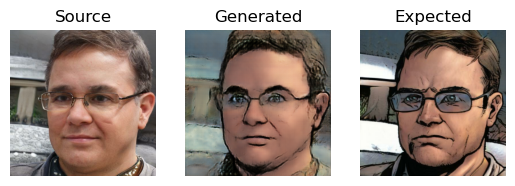

In [38]:
X1 = ff.next()[0]
X2 = cc.next()[0]
src_image, tar_image = X1, X2
# generate image from source
# gen_image = g_model.predict(src_image)
gen_image = g_model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

#### BEN

In [21]:
def preprocess_data(photo_list):
    # load compressed arrays
    # unpack arrays
    # scale from [0,255] to [-1,1]
    for i in range(len(photo_list)):
        photo_list[i] = (photo_list[i] - 127.5) / 127.5
    return photo_list


src_list = preprocess_data(src_list)

1/1 [==============================] - 0s 173ms/step


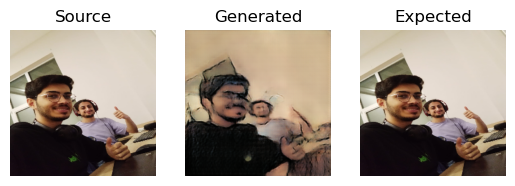

In [40]:
img_index = 2
src_image, tar_image = np.expand_dims(src_list[img_index], axis=0) , np.expand_dims(src_list[img_index], axis=0)
# generate image from source
# gen_image = g_model.predict(src_image)
gen_image = g_model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [26]:
g_model.save("comicGAN2epoch.h5")

C:\Users\Eren\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp comicGAN3kbatch.h5 /content/drive/MyDrive/